# Automatic Data Recognition Project - HIT

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
plt.style.use('ggplot')

from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check if TensorFlow is built with CUDA (GPU) support
print("Built with CUDA:", tf.test.is_built_with_cuda())

# Check if GPU is available
print("GPU available:", tf.config.list_physical_devices('GPU'))


Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Uploading Data

In [4]:
# Load the dataset
data_path = r'C:\Users\ADMIN\Downloads\Train (2).csv'
try:
    df = pd.read_csv(data_path)
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # Drop irrelevant columns
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File not found at {data_path}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Display the first few rows of the dataset
df.head()

Data loaded successfully.


,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,FlowCool Pressure Dropped Below Limit,Flowcool Pressure Too High Check Flowcool Pump,Flowcool leak
0,3283162,08M01,366,2465,10511435,481,3,-0.018959,-0.132713,0.012500,...,-0.511561,-0.08616,1.0,1.658163,0.209741,0.487876,-0.696642,0,0,0
1,3283166,08M01,366,2465,10511435,481,3,-0.018959,-0.131884,0.014437,...,-0.511561,-0.08616,1.0,1.658165,0.209744,0.487879,-0.696642,0,0,0
2,3283170,08M01,366,2465,10511435,481,3,-0.018959,-0.132437,0.001577,...,-0.511561,-0.08616,1.0,1.658167,0.209747,0.487882,-0.696642,0,0,0
3,3283174,08M01,366,2465,10511435,481,3,-0.018959,-0.132713,0.018836,...,-0.511561,-0.08616,1.0,1.658170,0.209750,0.487885,-0.696642,0,0,0
4,3283178,08M01,366,2465,10511435,481,3,-0.018959,-0.131607,0.006156,...,-0.511561,-0.08616,1.0,1.658172,0.209752,0.487888,-0.696642,0,0,0


## Data Preprocessing

In [5]:
# Drop the 'Tool' column
df = df.drop('Tool', axis=1)

# Adjust the 'time' column to start from zero
df['time'] = df['time'] - df.loc[0, 'time']

# Display the column names to understand the data structure
df.columns

Index(['time', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step',
       'IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
       'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
       'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
       'FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE',
       'FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER',
       'ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION',
       'FlowCool Pressure Dropped Below Limit',
       'Flowcool Pressure Too High Check Flowcool Pump', 'Flowcool leak'],
      dtype='object')

In [6]:
# Create a new 'fault' column to indicate any faults based on existing columns
df['fault'] = df[['FlowCool Pressure Dropped Below Limit', 
                  'Flowcool Pressure Too High Check Flowcool Pump', 
                  'Flowcool leak']].max(axis=1)

# Convert categorical columns to the 'object' data type
cat_cols = ['stage', 'Lot', 'recipe', 'recipe_step', 'fault']
for col in cat_cols:
    df[col] = df[col].astype('object')

# Display data types to ensure correct conversions
df.dtypes

df

,time,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,...,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,FlowCool Pressure Dropped Below Limit,Flowcool Pressure Too High Check Flowcool Pump,Flowcool leak,fault
0,0,366,2465,10511435,481,3,-0.018959,-0.132713,0.012500,0.159069,...,-0.086160,1.0,1.658163,0.209741,0.487876,-0.696642,0,0,0,0
1,4,366,2465,10511435,481,3,-0.018959,-0.131884,0.014437,0.159122,...,-0.086160,1.0,1.658165,0.209744,0.487879,-0.696642,0,0,0,0
2,8,366,2465,10511435,481,3,-0.018959,-0.132437,0.001577,0.158967,...,-0.086160,1.0,1.658167,0.209747,0.487882,-0.696642,0,0,0,0
3,12,366,2465,10511435,481,3,-0.018959,-0.132713,0.018836,0.158861,...,-0.086160,1.0,1.658170,0.209750,0.487885,-0.696642,0,0,0,0
4,16,366,2465,10511435,481,3,-0.018959,-0.131607,0.006156,0.158967,...,-0.086160,1.0,1.658172,0.209752,0.487888,-0.696642,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716087,35787922,251,4019,12791590,481,3,0.002410,-0.132437,0.011794,0.158758,...,-0.086172,1.0,0.359193,-1.598349,-1.357426,0.752712,0,0,0,0
3716088,35787926,251,4019,12791590,481,3,0.002410,-0.131607,0.016193,0.158861,...,-0.086172,1.0,0.359195,-1.598346,-1.357423,0.752712,0,0,0,0
3716089,35787930,251,4019,12791590,481,3,0.002410,-0.130643,0.008446,0.158655,...,-0.086172,1.0,0.359197,-1.598345,-1.357422,0.752712,0,0,0,0
3716090,35787934,251,4019,12791590,481,3,0.002410,-0.132160,0.001757,0.158705,...,-0.086172,1.0,0.359199,-1.598340,-1.357417,0.752712,0,0,0,0


In [7]:
for cols in cat_cols :
    display(df[cols].value_counts()[:5])

1      1100418
368     905871
159     510607
366     382332
127     355300
Name: stage, dtype: int64

29924    22967
3539     10402
1726      7834
29953     7640
5312      7495
Name: Lot, dtype: int64

1      1032667
483     908446
481     594931
488     271890
482     246731
Name: recipe, dtype: int64

3    1864676
1     690812
5     341360
7     328938
9     158160
Name: recipe_step, dtype: int64

0    3702399
1      13693
Name: fault, dtype: int64

In [8]:
df.loc[:, df.dtypes != 'object'].describe().T

,count,mean,std,min,25%,50%,75%,max
time,3716092.0,1.726496e+07,1.051923e+07,0.000000e+00,8.051383e+06,1.656938e+07,2.640765e+07,3.578794e+07
runnum,3716092.0,1.161875e+07,6.742565e+05,1.051144e+07,1.102146e+07,1.159068e+07,1.220795e+07,1.279159e+07
IONGAUGEPRESSURE,3716092.0,7.228964e-02,1.062290e+00,-1.398065e+00,-6.528662e-01,-4.254647e-02,6.942102e-01,1.221057e+01
ETCHBEAMVOLTAGE,3716092.0,7.527411e-02,1.061985e+00,-1.183464e+00,-9.950901e-01,-1.320250e-01,3.130377e-01,2.990426e+00
ETCHBEAMCURRENT,3716092.0,6.210291e-02,1.047372e+00,-1.265990e+00,-1.255070e+00,9.504391e-03,1.954174e-02,7.886841e+00
ETCHSUPPRESSORVOLTAGE,3716092.0,4.812758e-02,1.043921e+00,-1.492061e+00,-1.242156e+00,1.588111e-01,1.594834e-01,1.486380e+00
ETCHSUPPRESSORCURRENT,3716092.0,4.701532e-02,1.055358e+00,-9.167712e-01,-9.053048e-01,-2.621425e-01,-7.972162e-02,3.209554e+01
FLOWCOOLFLOWRATE,3716092.0,-1.198392e-02,1.009149e+00,-2.096811e+00,4.794529e-01,4.814269e-01,4.834043e-01,1.353718e+00
FLOWCOOLPRESSURE,3716092.0,3.238756e-02,9.802565e-01,-1.631780e+00,1.689002e-01,2.102259e-01,3.632811e-01,1.098072e+01
ETCHGASCHANNEL1READBACK,3716092.0,6.461428e-02,1.044237e+00,-1.300688e+00,-1.714920e-01,-1.584972e-01,1.551932e+00,5.540091e+00


In [9]:
df.isnull().sum()

time                                              0
stage                                             0
Lot                                               0
runnum                                            0
recipe                                            0
recipe_step                                       0
IONGAUGEPRESSURE                                  0
ETCHBEAMVOLTAGE                                   0
ETCHBEAMCURRENT                                   0
ETCHSUPPRESSORVOLTAGE                             0
ETCHSUPPRESSORCURRENT                             0
FLOWCOOLFLOWRATE                                  0
FLOWCOOLPRESSURE                                  0
ETCHGASCHANNEL1READBACK                           0
ETCHPBNGASREADBACK                                0
FIXTURETILTANGLE                                  0
ROTATIONSPEED                                     0
ACTUALROTATIONANGLE                               0
FIXTURESHUTTERPOSITION                            0
ETCHSOURCEUS

In [10]:
# reducing RAM usage by converting int64 and float64 to 16bits
for cols in df.columns.values :
    if df[cols].dtypes == 'int64' :
        if (cols == 'runnum') or (cols == 'time'):
            continue
        df[cols] = df[cols].astype('int16')
    elif df[cols].dtypes == 'float64' :
        df[cols] = df[cols].astype('float16')

df.dtypes

time                                                int64
stage                                              object
Lot                                                object
runnum                                              int64
recipe                                             object
recipe_step                                        object
IONGAUGEPRESSURE                                  float16
ETCHBEAMVOLTAGE                                   float16
ETCHBEAMCURRENT                                   float16
ETCHSUPPRESSORVOLTAGE                             float16
ETCHSUPPRESSORCURRENT                             float16
FLOWCOOLFLOWRATE                                  float16
FLOWCOOLPRESSURE                                  float16
ETCHGASCHANNEL1READBACK                           float16
ETCHPBNGASREADBACK                                float16
FIXTURETILTANGLE                                  float16
ROTATIONSPEED                                     float16
ACTUALROTATION

In [11]:
# Label Encoding
for cols in cat_cols :
    le = LabelEncoder()
    df[cols] = le.fit_transform(list(df[cols])).astype('int16')

df.dtypes

time                                                int64
stage                                               int16
Lot                                                 int16
runnum                                              int64
recipe                                              int16
recipe_step                                         int16
IONGAUGEPRESSURE                                  float16
ETCHBEAMVOLTAGE                                   float16
ETCHBEAMCURRENT                                   float16
ETCHSUPPRESSORVOLTAGE                             float16
ETCHSUPPRESSORCURRENT                             float16
FLOWCOOLFLOWRATE                                  float16
FLOWCOOLPRESSURE                                  float16
ETCHGASCHANNEL1READBACK                           float16
ETCHPBNGASREADBACK                                float16
FIXTURETILTANGLE                                  float16
ROTATIONSPEED                                     float16
ACTUALROTATION

## EDA



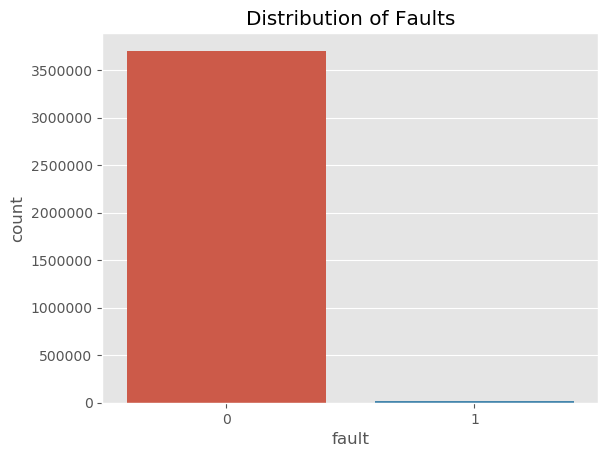

In [12]:
# Visualize the distribution of the 'fault' column
sns.countplot(x='fault', data=df)
plt.title('Distribution of Faults')
plt.show()

In [13]:
df['fault'].sum()

13693

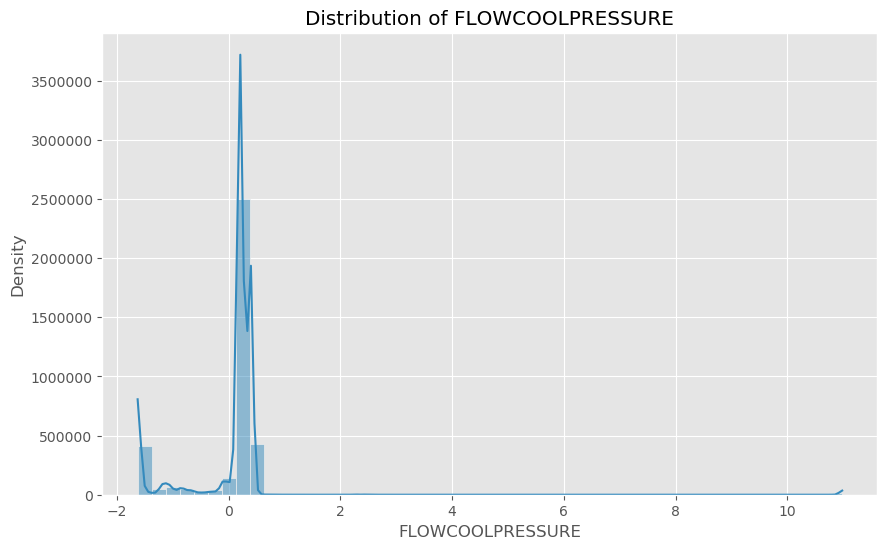

In [14]:
# distribution of FLOWCOOLPRESSURE
plt.figure(figsize=(10, 6))
sns.histplot(df['FLOWCOOLPRESSURE'], kde=True, bins=50)
plt.title('Distribution of FLOWCOOLPRESSURE')
plt.xlabel('FLOWCOOLPRESSURE')
plt.ylabel('Density')
plt.show()

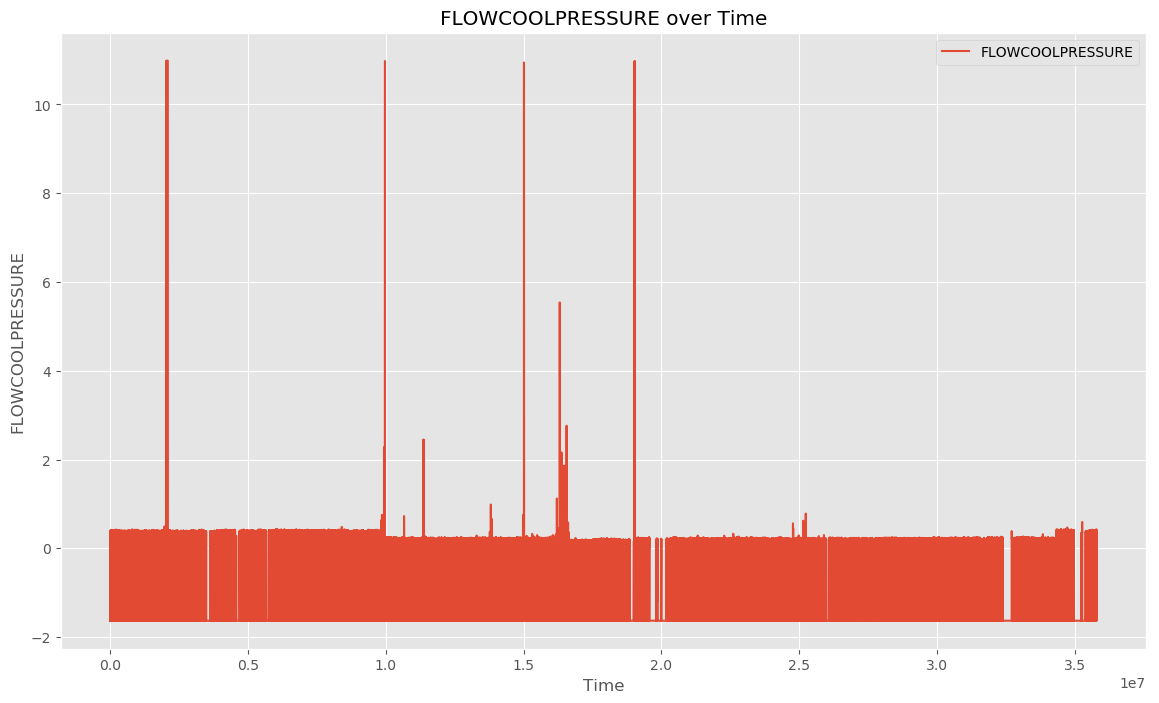

In [15]:
# FLOWCOOLPRESSURE over time
plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['FLOWCOOLPRESSURE'], label='FLOWCOOLPRESSURE')
plt.title('FLOWCOOLPRESSURE over Time')
plt.xlabel('Time')
plt.ylabel('FLOWCOOLPRESSURE')
plt.legend()
plt.show()

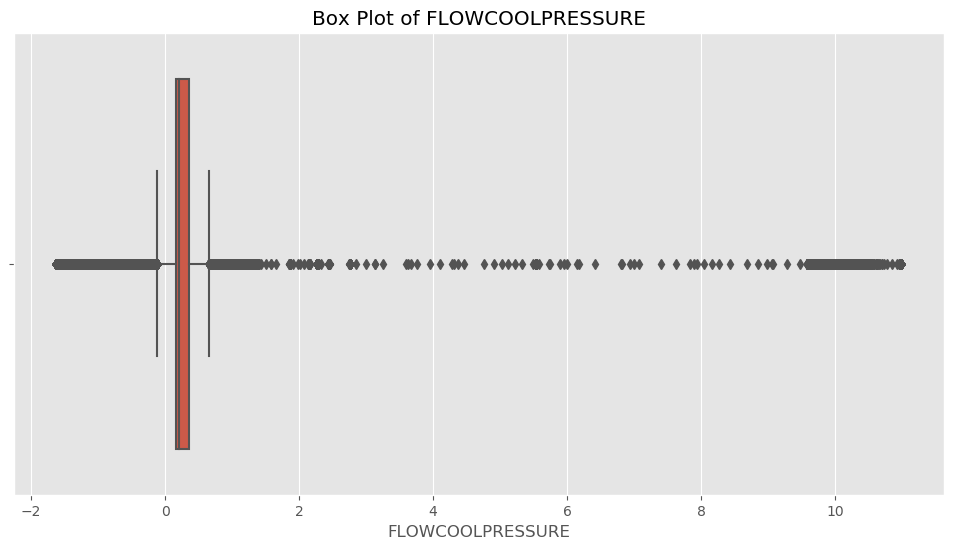

In [16]:
# Boxplot of FLOWCOOLPRESSURE
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['FLOWCOOLPRESSURE'])
plt.title('Box Plot of FLOWCOOLPRESSURE')
plt.xlabel('FLOWCOOLPRESSURE')
plt.show()

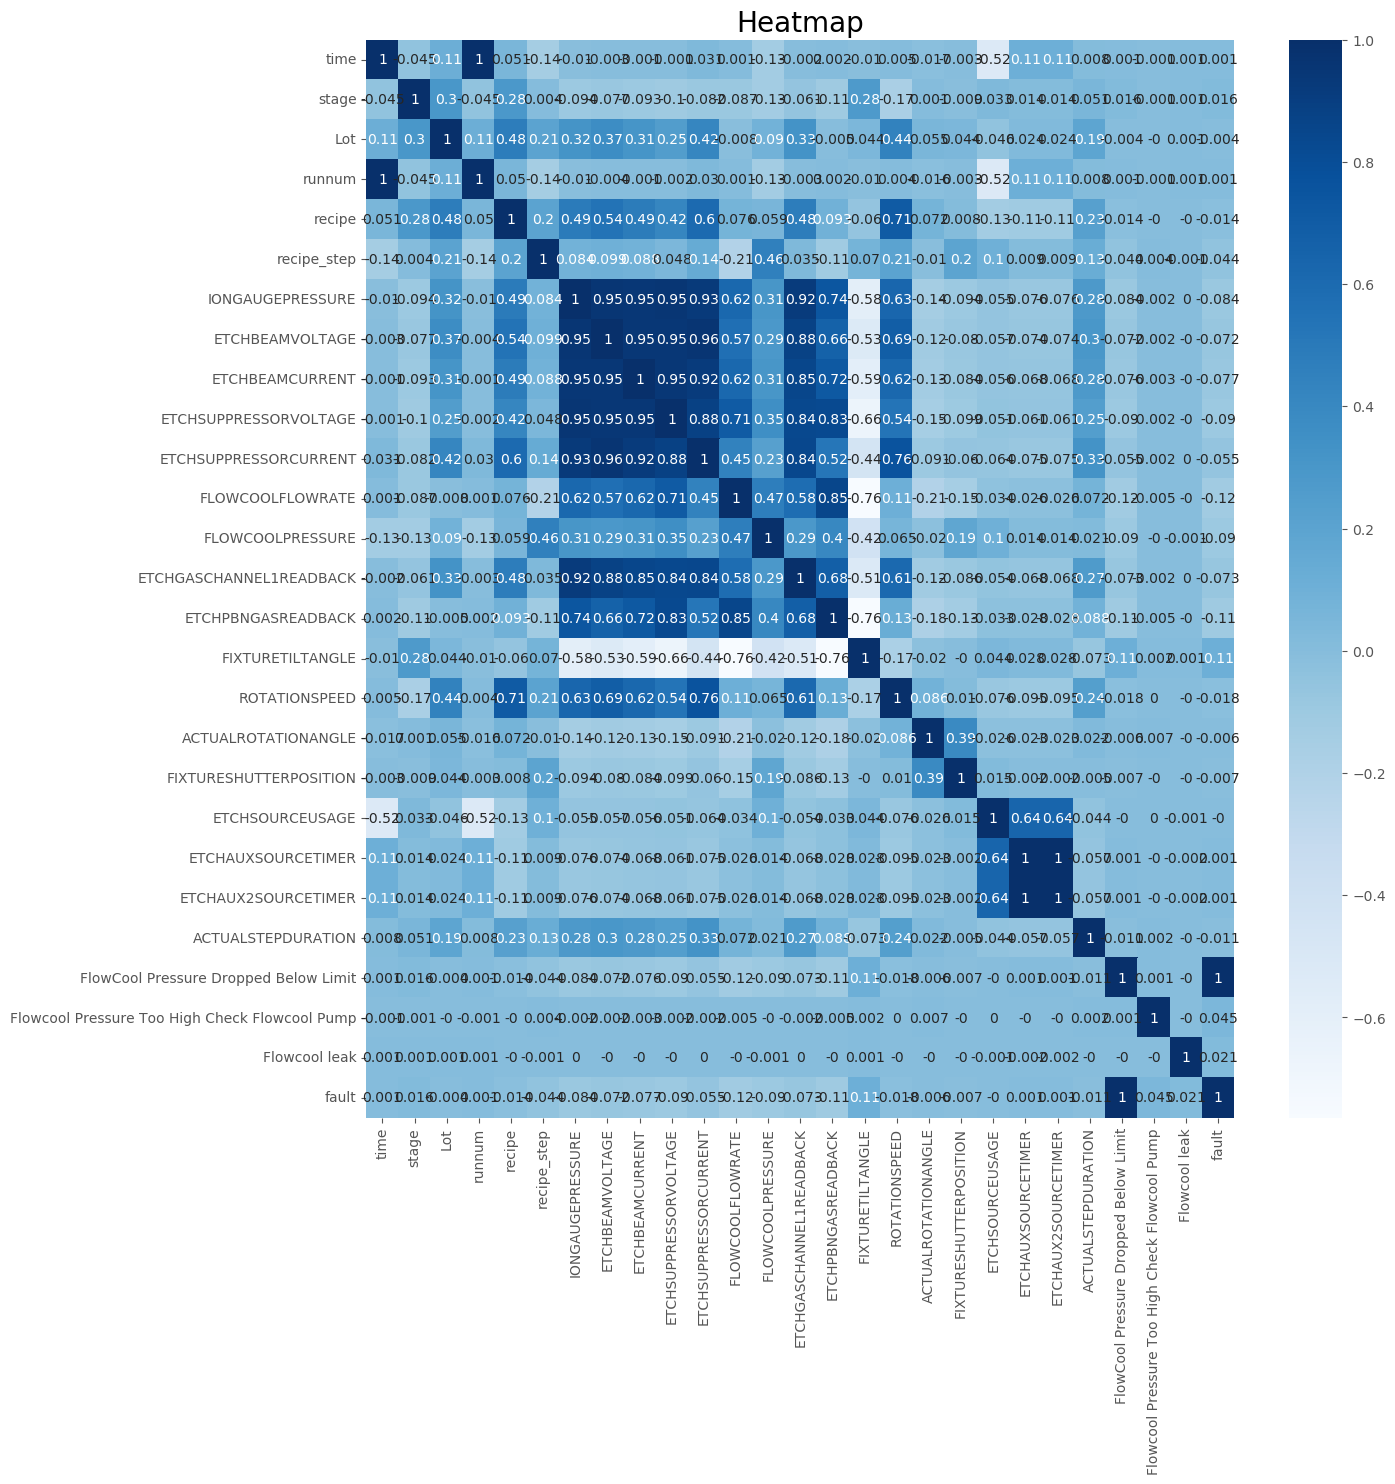

In [17]:
# Heatmap
data_corr = df.corr()
data_corr = data_corr.apply(lambda x : round(x, 3))
plt.figure(figsize=(14, 14))
sns.heatmap(data_corr, annot=True,cmap='Blues')
plt.title('Heatmap', fontsize=20)
plt.show()

In [18]:
df.select_dtypes(include=[np.number]).corr()['FLOWCOOLPRESSURE'].sort_values(ascending=False)

FLOWCOOLPRESSURE                                  1.000000
FLOWCOOLFLOWRATE                                  0.469999
recipe_step                                       0.455765
ETCHPBNGASREADBACK                                0.401344
ETCHSUPPRESSORVOLTAGE                             0.354330
IONGAUGEPRESSURE                                  0.309426
ETCHBEAMCURRENT                                   0.308213
ETCHBEAMVOLTAGE                                   0.287878
ETCHGASCHANNEL1READBACK                           0.287012
ETCHSUPPRESSORCURRENT                             0.227399
FIXTURESHUTTERPOSITION                            0.185838
ETCHSOURCEUSAGE                                   0.101989
Lot                                               0.089575
ROTATIONSPEED                                     0.065126
recipe                                            0.058677
ACTUALSTEPDURATION                                0.021465
ETCHAUXSOURCETIMER                                0.0143

## Clustering

### Standardization and PCA

Use the most correlated features for clustering to reduce dimensionality and focus on the most relevant aspects of the data.

In [19]:
features = [
    'FLOWCOOLPRESSURE', 'FLOWCOOLFLOWRATE', 'recipe_step', 'ETCHPBNGASREADBACK', 
    'ETCHSUPPRESSORVOLTAGE', 'IONGAUGEPRESSURE', 'ETCHBEAMCURRENT', 
    'ETCHBEAMVOLTAGE', 'ETCHGASCHANNEL1READBACK', 'ETCHSUPPRESSORCURRENT'
]

In [20]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_scaled)

### MiniBatchKMeans

Finding the optimal number of clusters using elbow method:

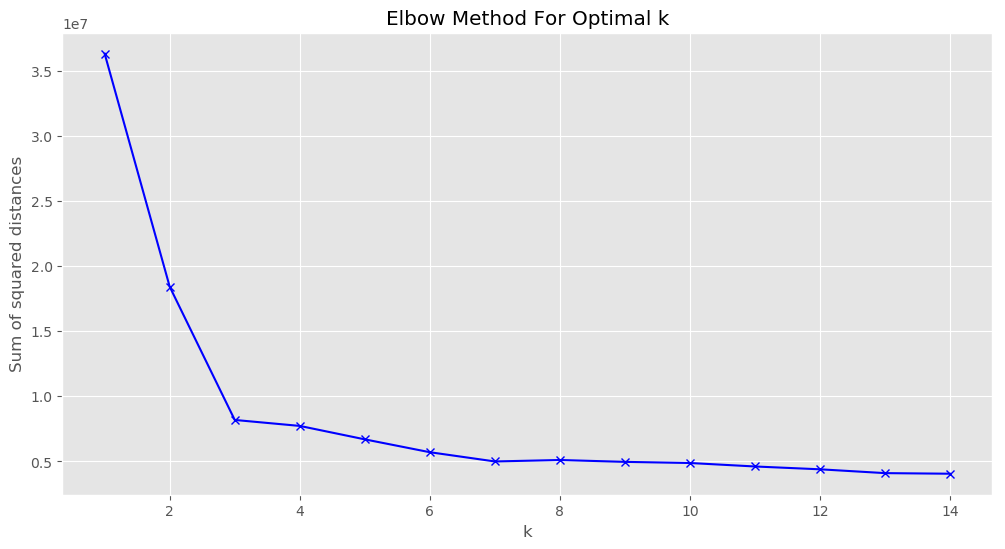

In [21]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=1)
    km = km.fit(df_pca)
    sum_of_squared_distances.append(km.inertia_)

# elbow method
plt.figure(figsize=(12, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on this plot the optimal number of clusters would be K=3 or K=4.

Let's start with K=3:

In [22]:
kmeans_3 = MiniBatchKMeans(n_clusters=3, random_state=1)
df['cluster_3'] = kmeans_3.fit_predict(df_pca)

Cluster Profile:

In [23]:
cluster_profile_3 = df.groupby('cluster_3').mean()
print(cluster_profile_3)

                   time     stage          Lot        runnum    recipe  \
cluster_3                                                                
0          1.755893e+07  8.727175  2894.388246  1.163806e+07  2.979069   
1          1.718251e+07  7.004832  2257.234813  1.161378e+07  1.937741   
2          1.715297e+07  7.071366  4395.520192  1.161043e+07  7.498802   

           recipe_step  IONGAUGEPRESSURE  ETCHBEAMVOLTAGE  ETCHBEAMCURRENT  \
cluster_3                                                                    
0             4.102854         -1.303711        -1.160156        -1.256836   
1             3.518316         -0.031174        -0.145142        -0.065247   
2             5.437066          1.654297         1.771484         1.638672   

           ETCHSUPPRESSORVOLTAGE  ...  ACTUALROTATIONANGLE  \
cluster_3                         ...                        
0                      -1.475586  ...             0.418945   
1                       0.096436  ...            -0.

Cluster Vis:

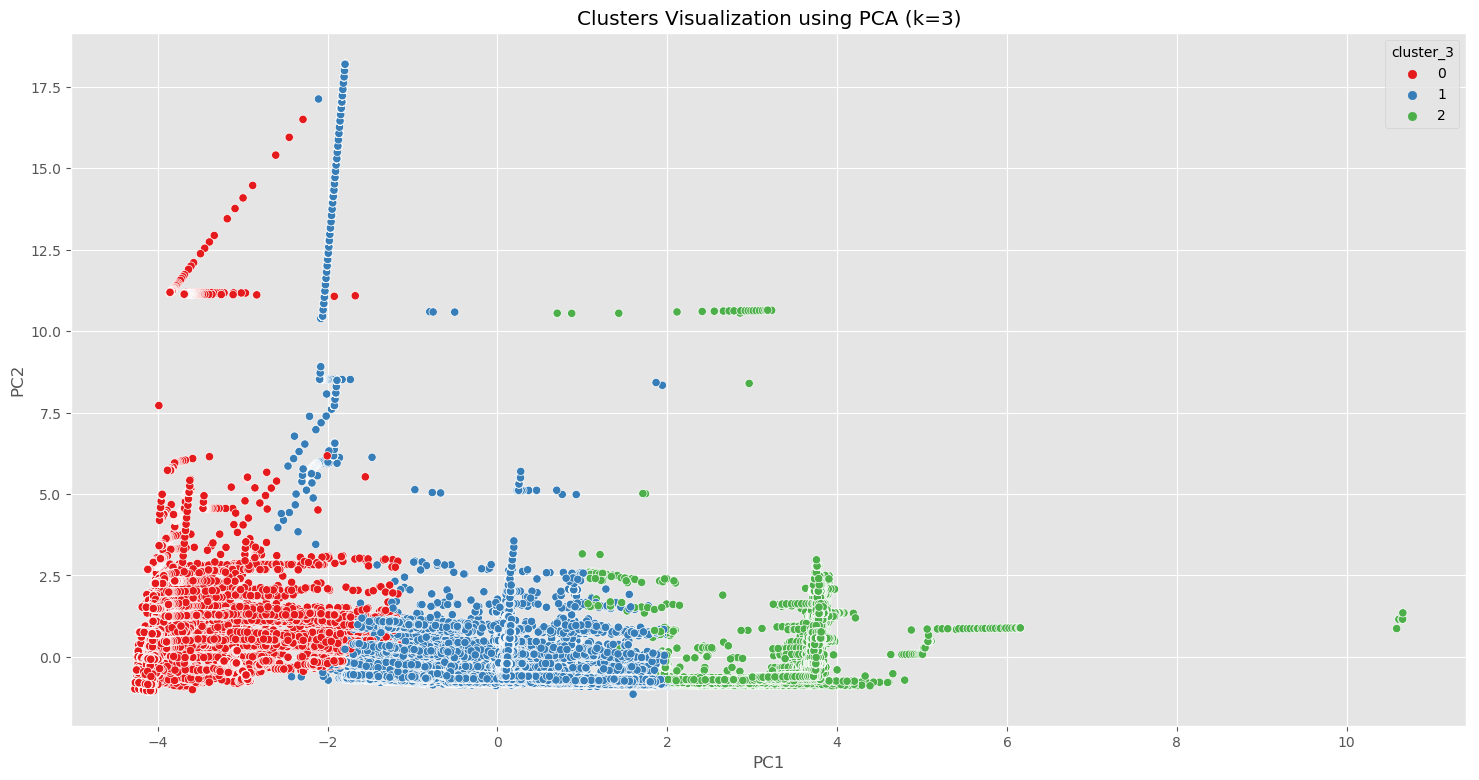

In [24]:
df['PC1'] = df_pca[:, 0]
df['PC2'] = df_pca[:, 1]

plt.figure(figsize=(18, 9))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_3', data=df, palette='Set1')
plt.title('Clusters Visualization using PCA (k=3)')
plt.show()

Let's do the same for K=4:

In [25]:
kmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=1)
df['cluster_4'] = kmeans_4.fit_predict(df_pca)

In [26]:
cluster_profile_4 = df.groupby('cluster_4').mean()
print(cluster_profile_4)

                   time     stage          Lot        runnum    recipe  \
cluster_4                                                                
0          1.755895e+07  8.727285  2894.398143  1.163806e+07  2.979089   
1          1.718551e+07  6.991123  2252.924617  1.161396e+07  1.936358   
2          1.452352e+07  6.274831  4300.276504  1.144031e+07  8.141422   
3          1.883118e+07  7.630691  4460.053468  1.171907e+07  7.060179   

           recipe_step  IONGAUGEPRESSURE  ETCHBEAMVOLTAGE  ETCHBEAMCURRENT  \
cluster_4                                                                    
0             4.103046         -1.303711        -1.160156        -1.256836   
1             3.519857         -0.032379        -0.146973        -0.067017   
2             9.477560          1.740234         1.800781         1.660156   
3             2.825724          1.594727         1.748047         1.622070   

           ETCHSUPPRESSORVOLTAGE  ...  ETCHAUXSOURCETIMER  \
cluster_4                

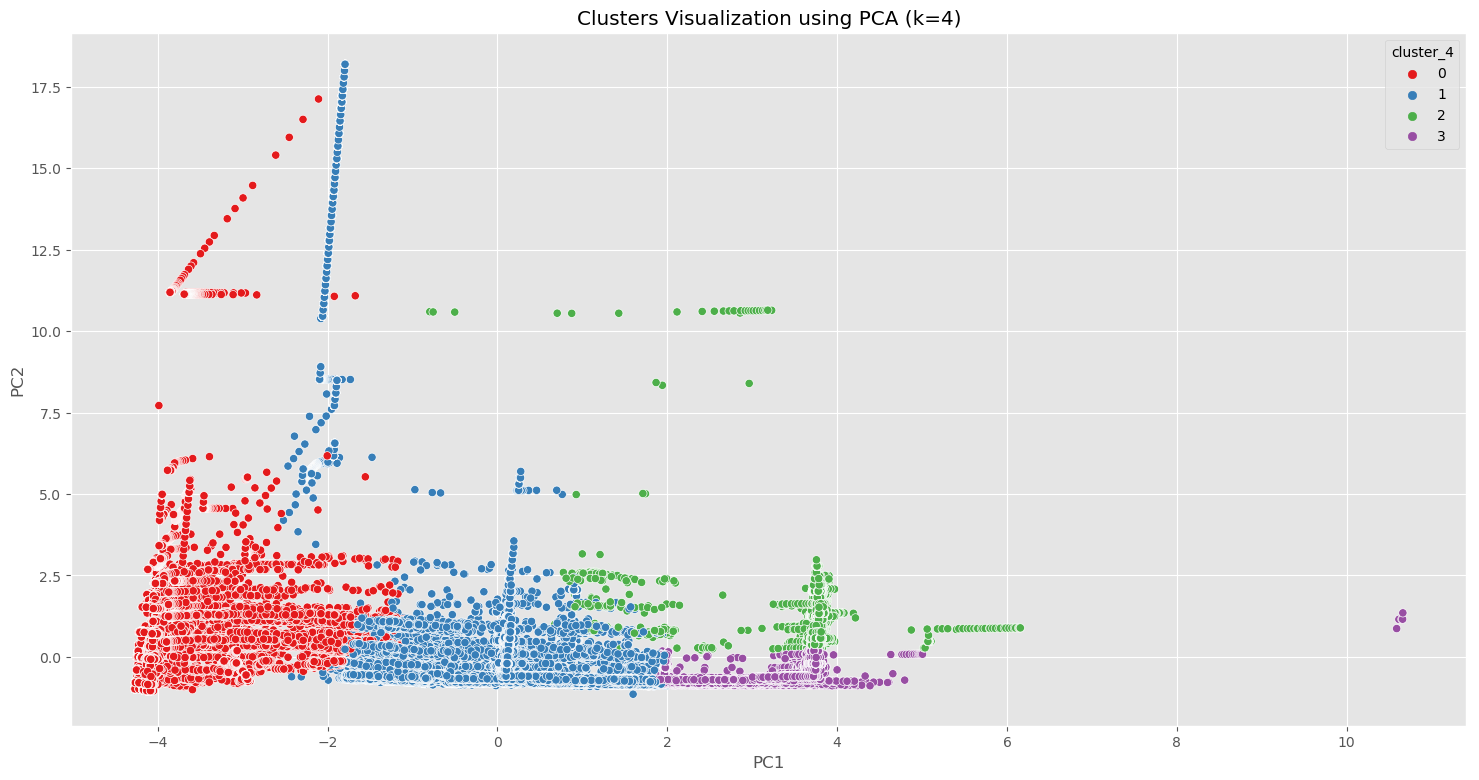

In [27]:
plt.figure(figsize=(18, 9))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_4', data=df, palette='Set1')
plt.title('Clusters Visualization using PCA (k=4)')
plt.show()

As we can see with K=4 we don't get a lot of differences between clusters 3 and 1 so we will stick to K=3.

In [28]:
df = df.drop(columns=['FlowCool Pressure Dropped Below Limit', 'Flowcool Pressure Too High Check Flowcool Pump', 'Flowcool leak'])

In [29]:
# some cleanups before we move on
pca_components = df[['PC1', 'PC2']]
df = df.drop(columns=['PC1', 'PC2', 'cluster_4'])
df.head()

,time,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,...,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,fault,cluster_3
0,0,12,1419,10511435,2,3,-0.018951,-0.132690,0.012497,0.159058,...,-0.981445,-0.511719,-0.086182,1.0,1.658203,0.209717,0.487793,-0.696777,0,1
1,4,12,1419,10511435,2,3,-0.018951,-0.131836,0.014435,0.159180,...,-0.981445,-0.511719,-0.086182,1.0,1.658203,0.209717,0.487793,-0.696777,0,1
2,8,12,1419,10511435,2,3,-0.018951,-0.132446,0.001576,0.158936,...,-0.981445,-0.511719,-0.086182,1.0,1.658203,0.209717,0.487793,-0.696777,0,1
3,12,12,1419,10511435,2,3,-0.018951,-0.132690,0.018829,0.158813,...,-0.981445,-0.511719,-0.086182,1.0,1.658203,0.209717,0.487793,-0.696777,0,1
4,16,12,1419,10511435,2,3,-0.018951,-0.131592,0.006157,0.158936,...,-0.981445,-0.511719,-0.086182,1.0,1.658203,0.209717,0.487793,-0.696777,0,1


### Clusters Analysis:

#### Feature Importance:

Implementing a function to check which features has had the most impact on the clustering process in order to analyze the clusters further.

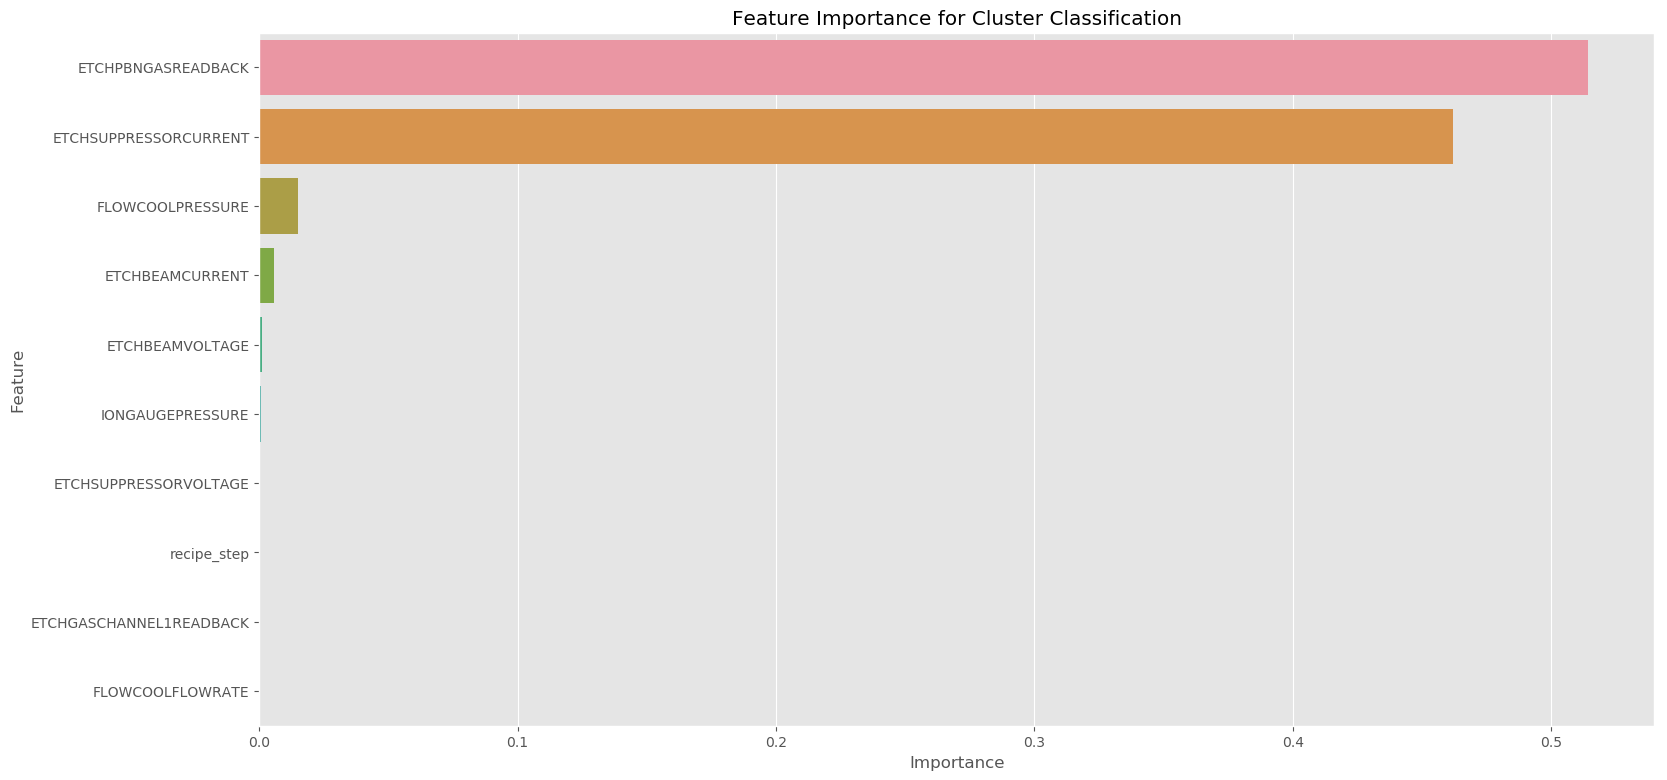

                   Feature  Importance
3       ETCHPBNGASREADBACK    0.514159
9    ETCHSUPPRESSORCURRENT    0.462160
0         FLOWCOOLPRESSURE    0.014880
6          ETCHBEAMCURRENT    0.005665
7          ETCHBEAMVOLTAGE    0.001123
5         IONGAUGEPRESSURE    0.000775
4    ETCHSUPPRESSORVOLTAGE    0.000354
2              recipe_step    0.000349
8  ETCHGASCHANNEL1READBACK    0.000300
1         FLOWCOOLFLOWRATE    0.000235


In [30]:
def calculate_feature_importance(df, cluster_col, features):
    X = df[features]
    y = df[cluster_col]

    # Fit a decision tree to find feature importance
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X, y)

    # Extract feature importance
    importances = tree.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(18, 9))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance for Cluster Classification')
    plt.show()

    return feature_importance_df

# Calculate feature importance for K=3 clusters
features_to_compare = [
    'FLOWCOOLPRESSURE', 'FLOWCOOLFLOWRATE', 'recipe_step', 'ETCHPBNGASREADBACK', 
    'ETCHSUPPRESSORVOLTAGE', 'IONGAUGEPRESSURE', 'ETCHBEAMCURRENT', 
    'ETCHBEAMVOLTAGE', 'ETCHGASCHANNEL1READBACK', 'ETCHSUPPRESSORCURRENT'
]
feature_importance_df = calculate_feature_importance(df, 'cluster_3', features_to_compare)
print(feature_importance_df)

As we can see ETCHPBNGASREADBACK, ETCHSUPPRESSORCURRENT and FLOWCOOLPRESSURE are the most prominent features that affected the clustering process.

#### Comparative Analysis:

Comparing the features across the clusters.


Comparative Analysis for Feature: ETCHPBNGASREADBACK

Cluster 1 Statistics:
count    1.936081e+06
mean              NaN
std      0.000000e+00
min     -2.082031e+00
25%      5.498047e-01
50%      5.605469e-01
75%      5.678711e-01
max      3.312500e+00
Name: ETCHPBNGASREADBACK, dtype: float64

Cluster 0 Statistics:
count    884292.000000
mean               NaN
std           0.000000
min          -2.082031
25%          -1.802734
50%          -1.770508
75%          -1.739258
max           0.832031
Name: ETCHPBNGASREADBACK, dtype: float64

Cluster 2 Statistics:
count    895719.000000
mean               NaN
std           0.000000
min          -2.082031
25%           0.567871
50%           0.573242
75%           0.578125
max           3.312500
Name: ETCHPBNGASREADBACK, dtype: float64


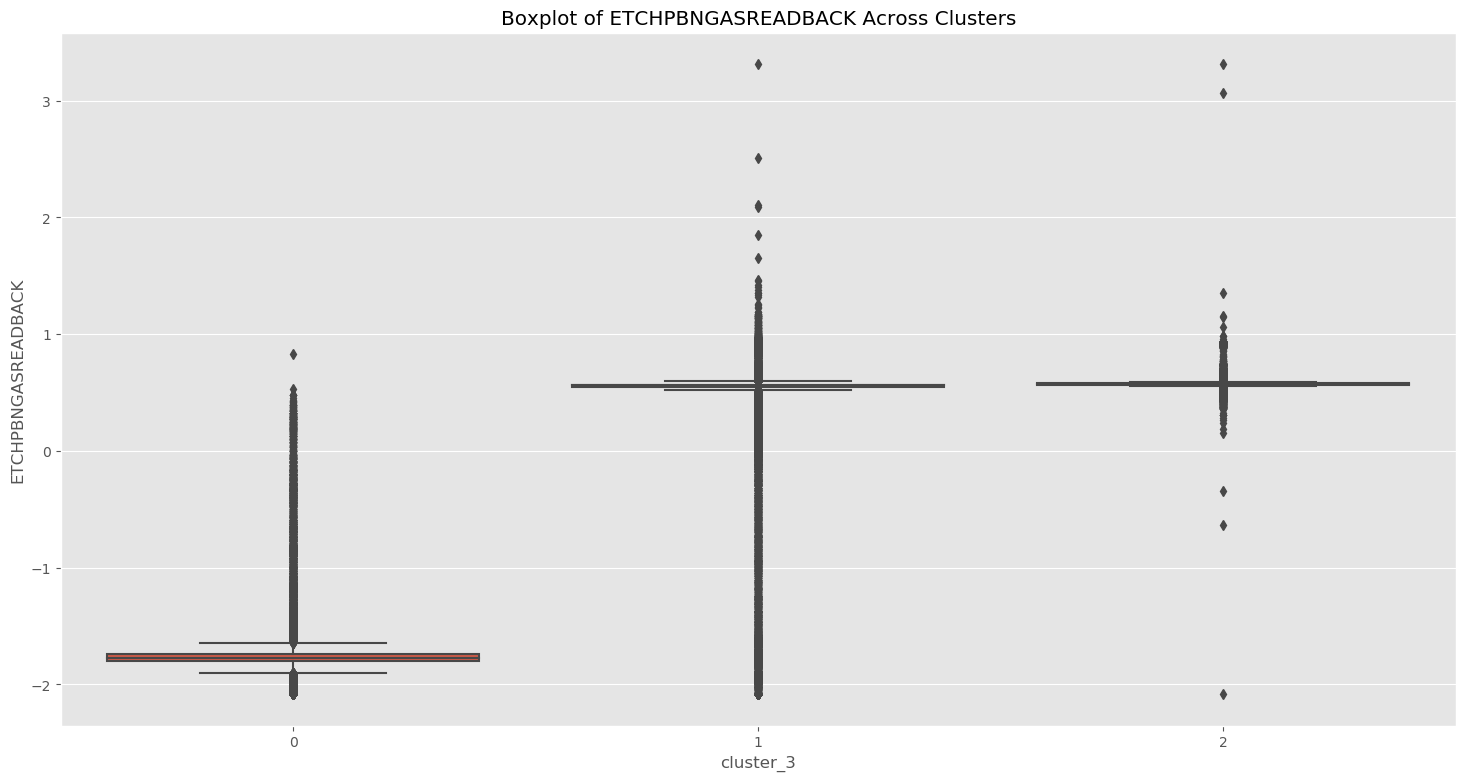

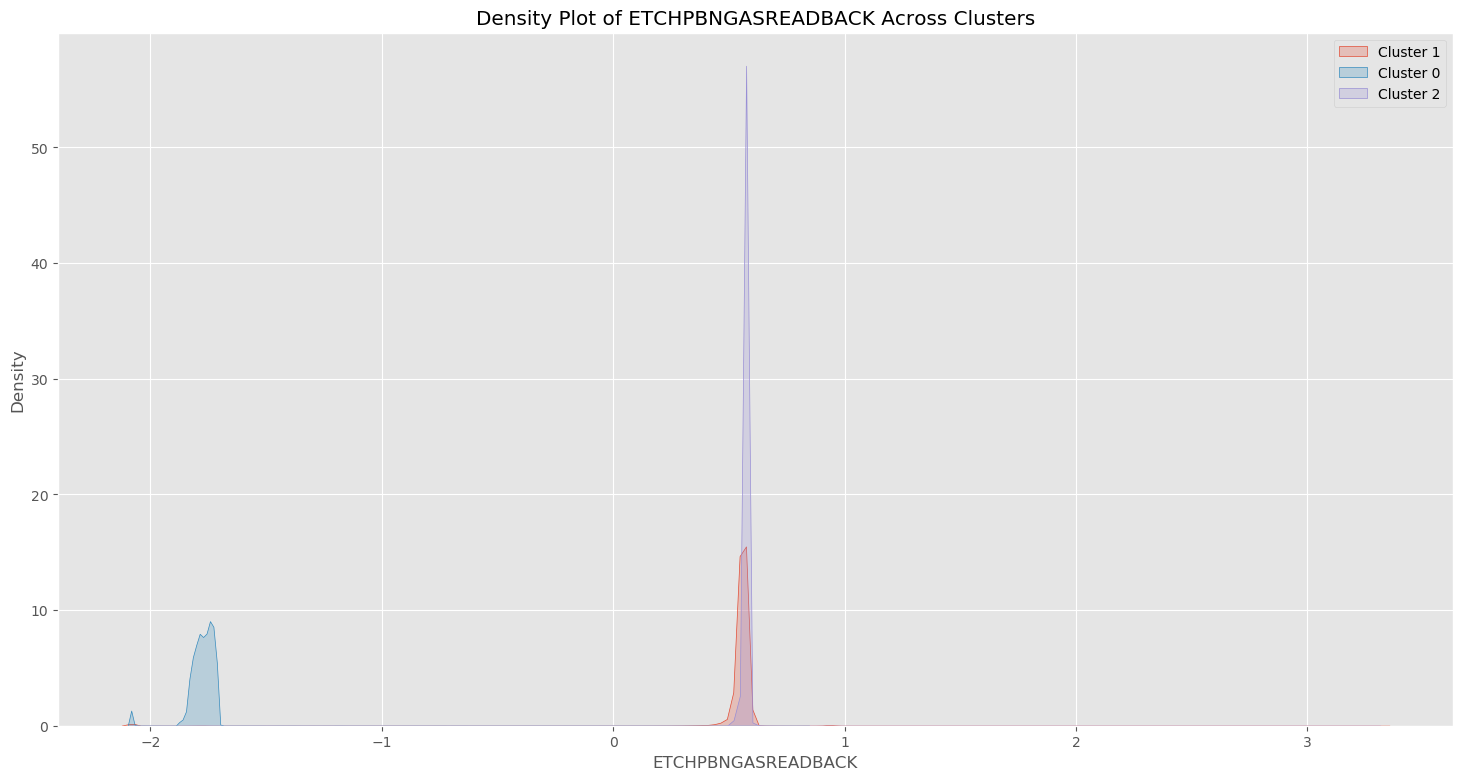


Comparative Analysis for Feature: ETCHSUPPRESSORCURRENT

Cluster 1 Statistics:
count    1.936081e+06
mean              NaN
std      0.000000e+00
min     -9.169922e-01
25%     -4.482422e-01
50%     -2.622070e-01
75%     -2.397461e-01
max      8.393555e-01
Name: ETCHSUPPRESSORCURRENT, dtype: float64

Cluster 0 Statistics:
count    884292.000000
mean               NaN
std           0.000000
min          -0.916992
25%          -0.916016
50%          -0.915039
75%          -0.913574
max          -0.090637
Name: ETCHSUPPRESSORCURRENT, dtype: float64

Cluster 2 Statistics:
count    895719.000000
mean               NaN
std           0.000000
min          -0.916992
25%           1.759766
50%           1.912109
75%           2.007812
max          32.093750
Name: ETCHSUPPRESSORCURRENT, dtype: float64


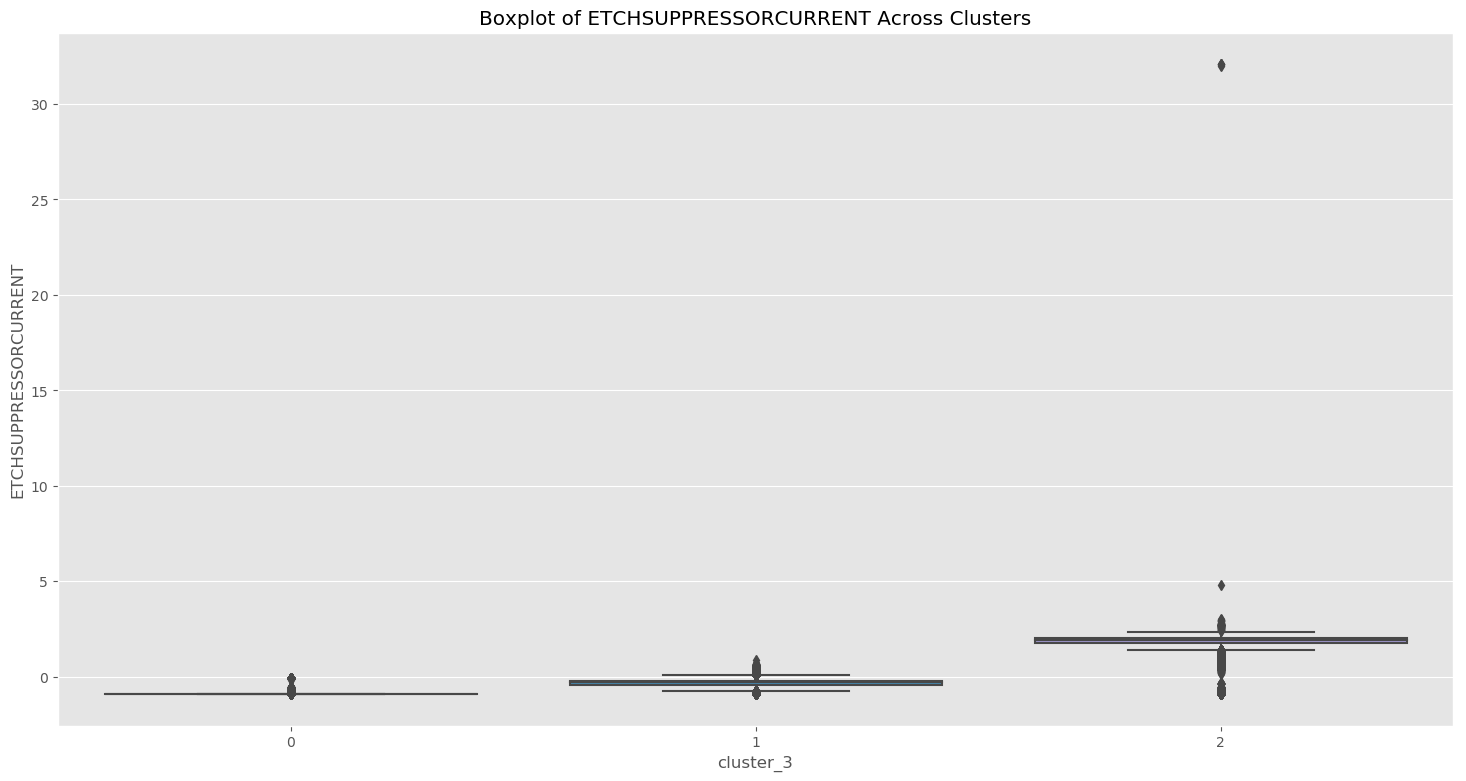

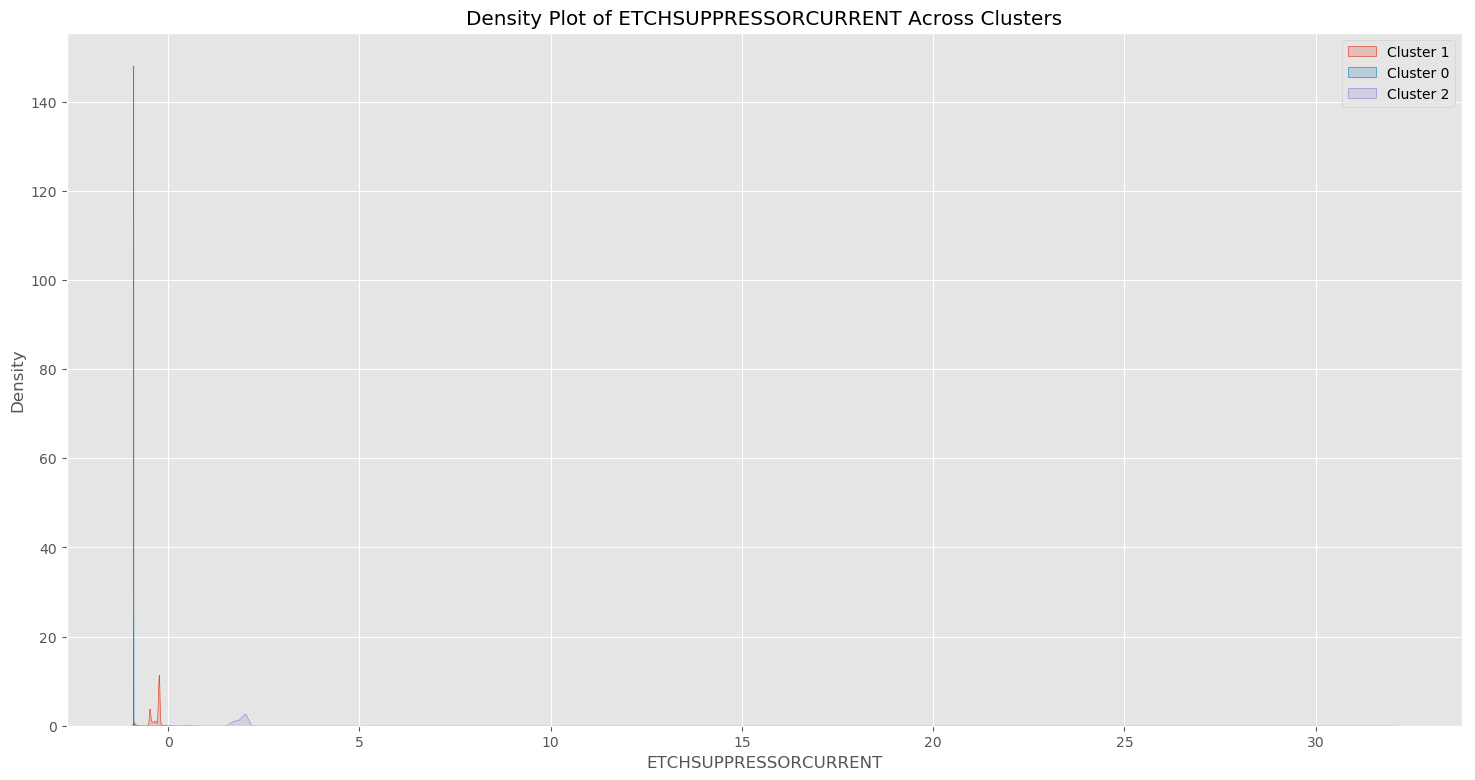


Comparative Analysis for Feature: FLOWCOOLPRESSURE

Cluster 1 Statistics:
count    1.936081e+06
mean              NaN
std      0.000000e+00
min     -1.631836e+00
25%      1.925049e-01
50%      2.128906e-01
75%      3.710938e-01
max      1.098438e+01
Name: FLOWCOOLPRESSURE, dtype: float64

Cluster 0 Statistics:
count    884292.000000
mean               NaN
std           0.000000
min          -1.631836
25%          -1.631836
50%          -1.194336
75%          -0.052277
max           7.933594
Name: FLOWCOOLPRESSURE, dtype: float64

Cluster 2 Statistics:
count    895719.000000
mean               NaN
std           0.000000
min          -1.631836
25%           0.216187
50%           0.228882
75%           0.393311
max          10.976562
Name: FLOWCOOLPRESSURE, dtype: float64


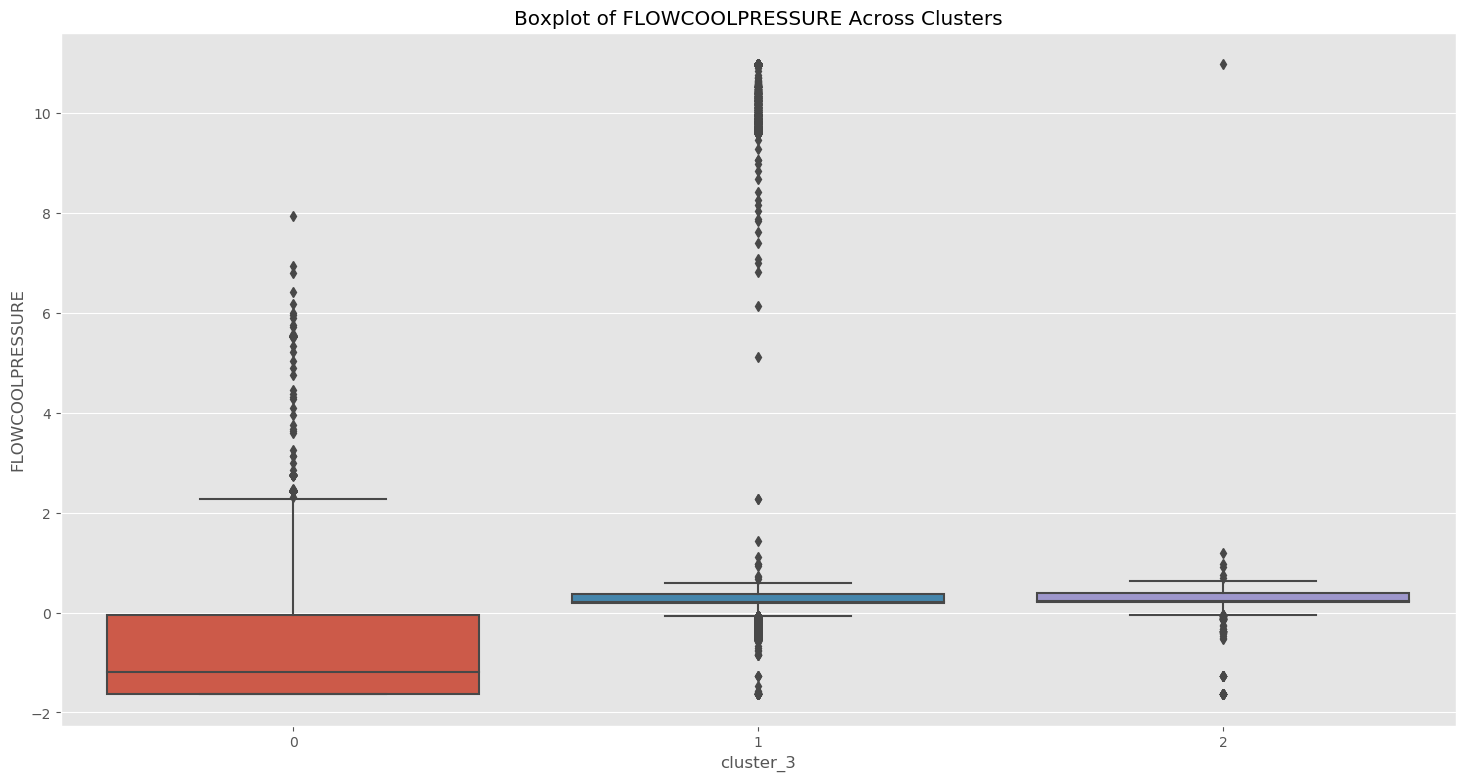

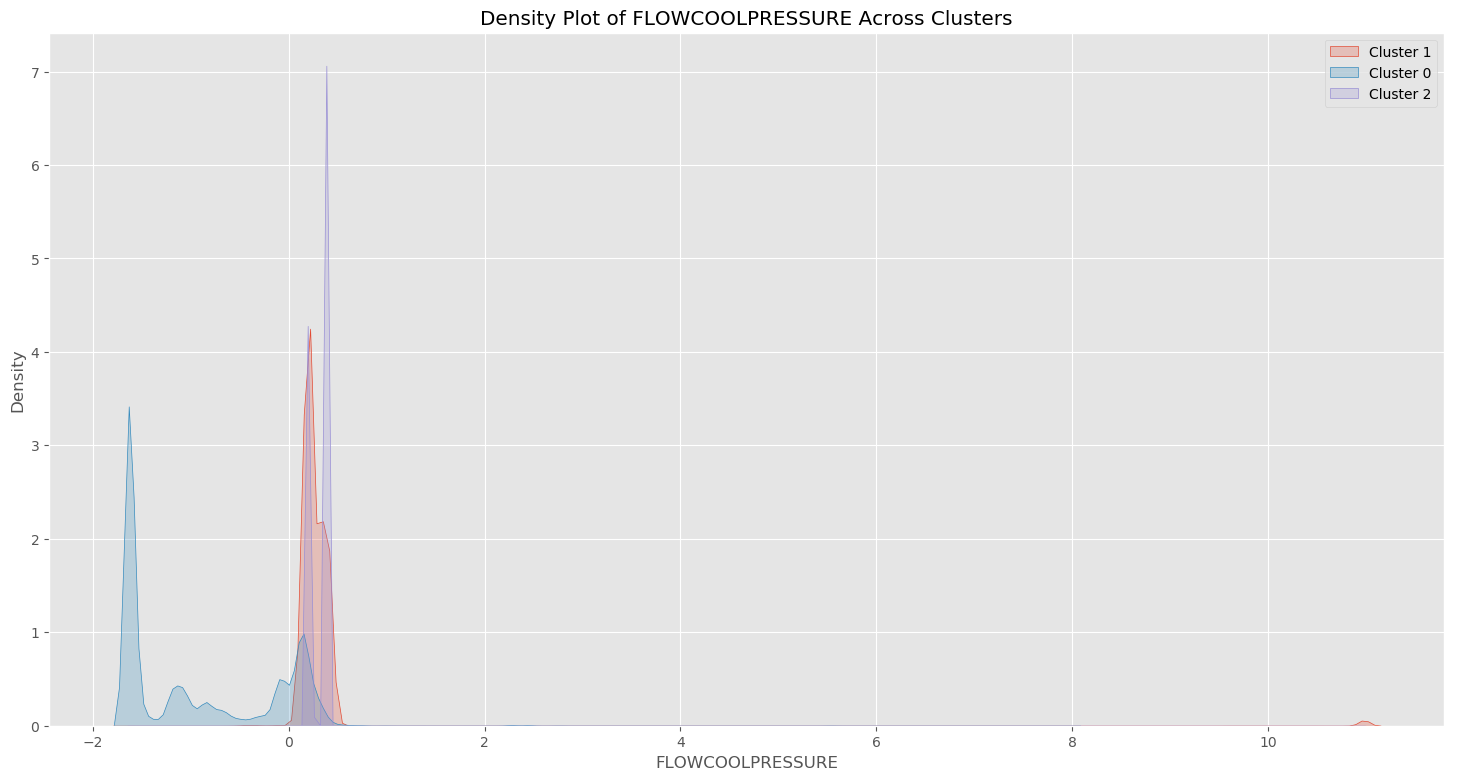

In [31]:
def comparative_analysis(df, cluster_col, top_features):
    clusters = df[cluster_col].unique()
    
    for feature in top_features:
        print(f"\nComparative Analysis for Feature: {feature}")

        # Display descriptive statistics for each cluster
        for cluster in clusters:
            cluster_df = df[df[cluster_col] == cluster]
            print(f"\nCluster {cluster} Statistics:")
            print(cluster_df[feature].describe())

        # Visualize with boxplots and density plots
        plt.figure(figsize=(18, 9))
        sns.boxplot(x=cluster_col, y=feature, data=df)
        plt.title(f'Boxplot of {feature} Across Clusters')
        plt.show()

        plt.figure(figsize=(18, 9))
        for cluster in clusters:
            cluster_df = df[df[cluster_col] == cluster]
            sns.kdeplot(cluster_df[feature], label=f'Cluster {cluster}', fill=True)
        plt.title(f'Density Plot of {feature} Across Clusters')
        plt.legend()
        plt.show()

# Run comparative analysis for the top 3 features
top_features = ['ETCHPBNGASREADBACK', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLPRESSURE']
comparative_analysis(df, 'cluster_3', top_features)


bonus barplot for me

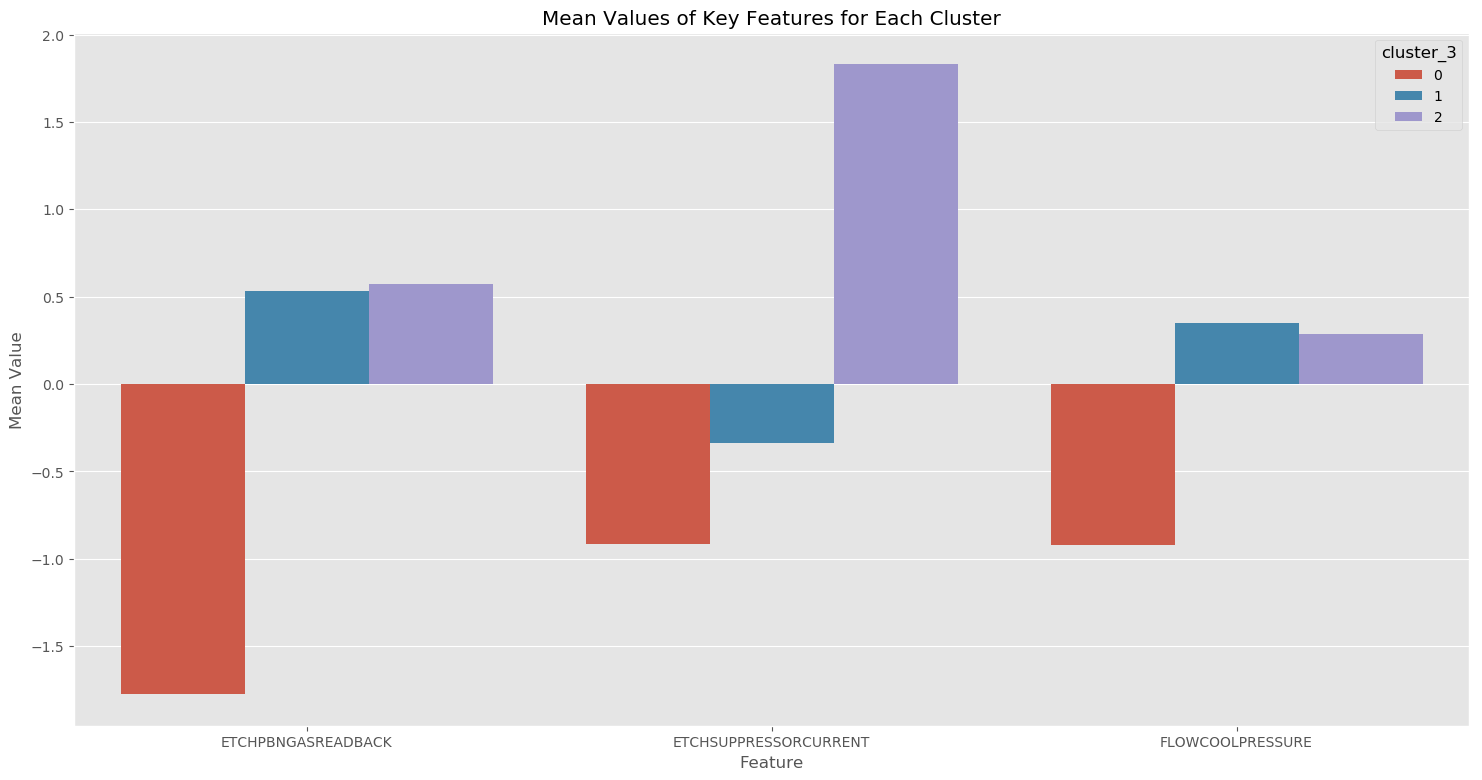

In [32]:
cluster_means = df.groupby('cluster_3')[top_features].mean().reset_index().melt(id_vars=['cluster_3'], var_name='Feature', value_name='Mean Value')
plt.figure(figsize=(18, 9))
sns.barplot(x='Feature', y='Mean Value', hue='cluster_3', data=cluster_means)
plt.title('Mean Values of Key Features for Each Cluster')
plt.show()

### Time Series Analysis in the Clusters:

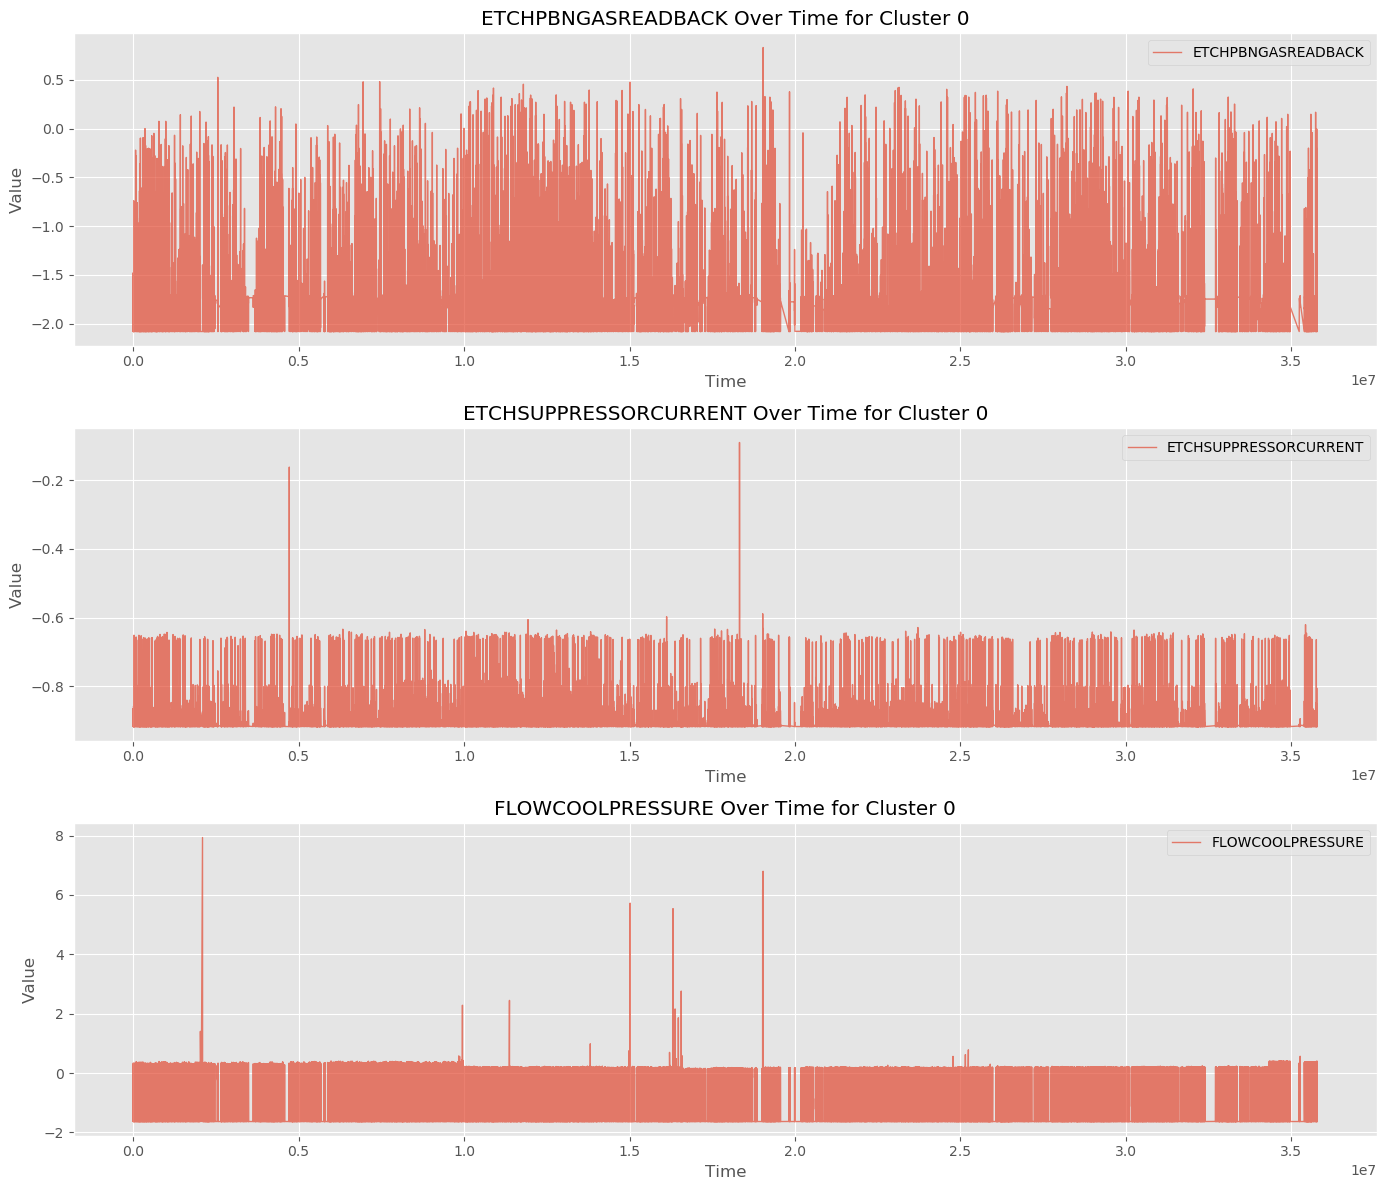

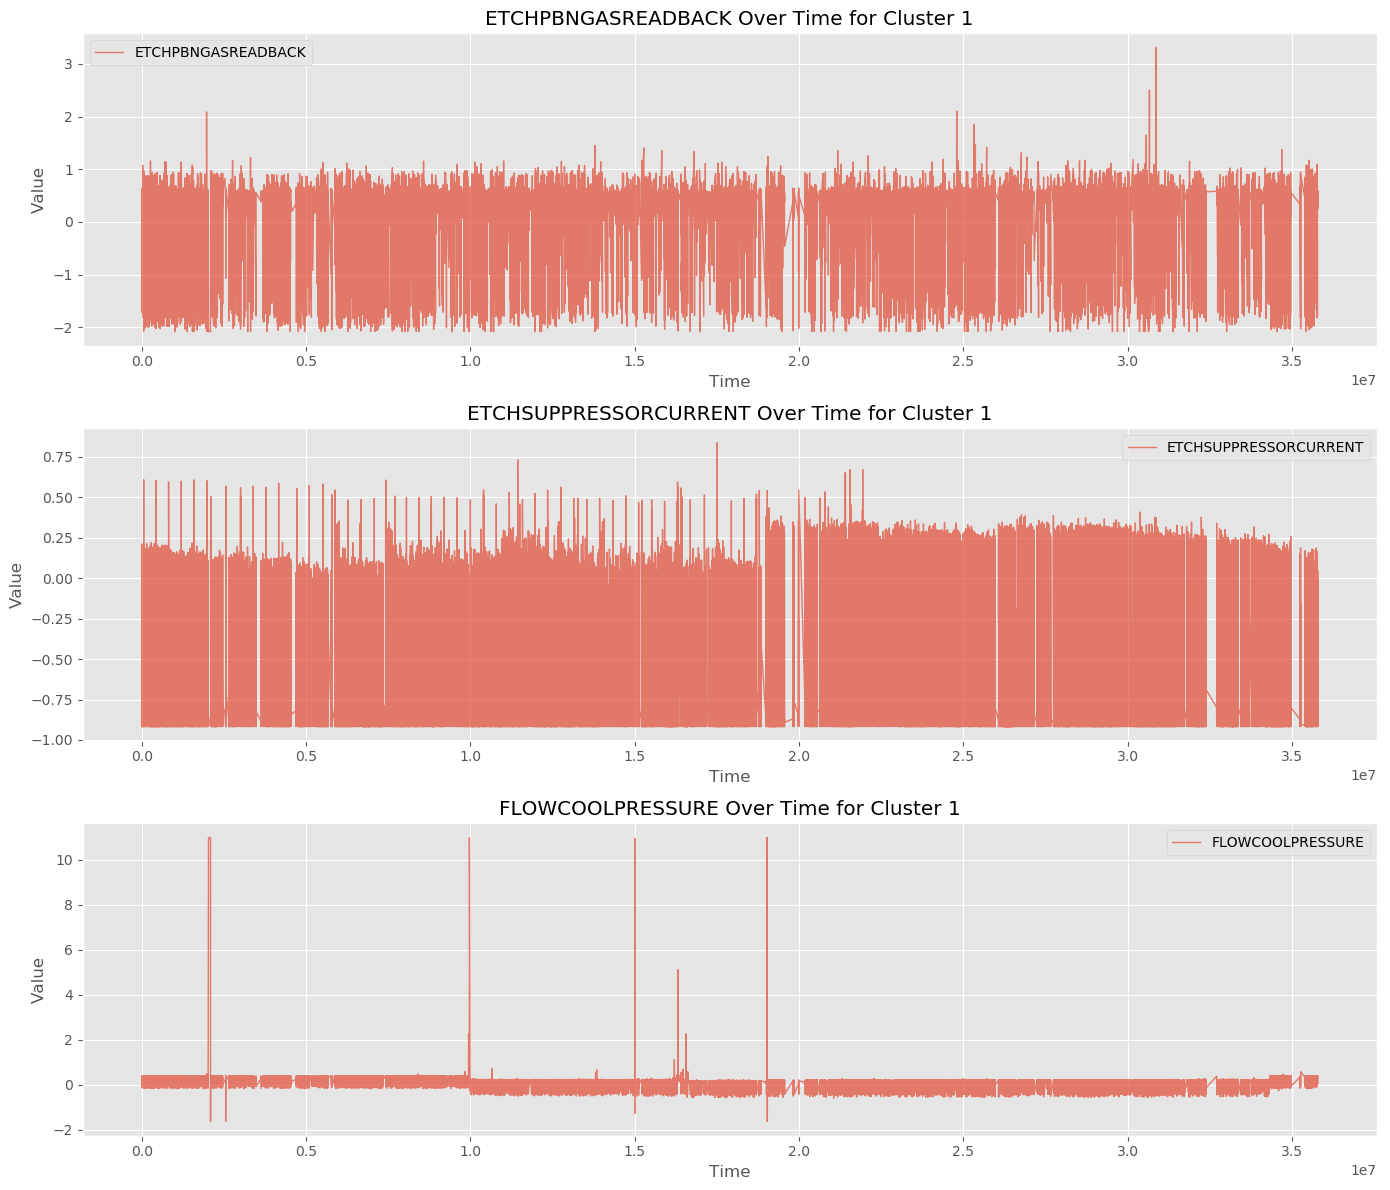

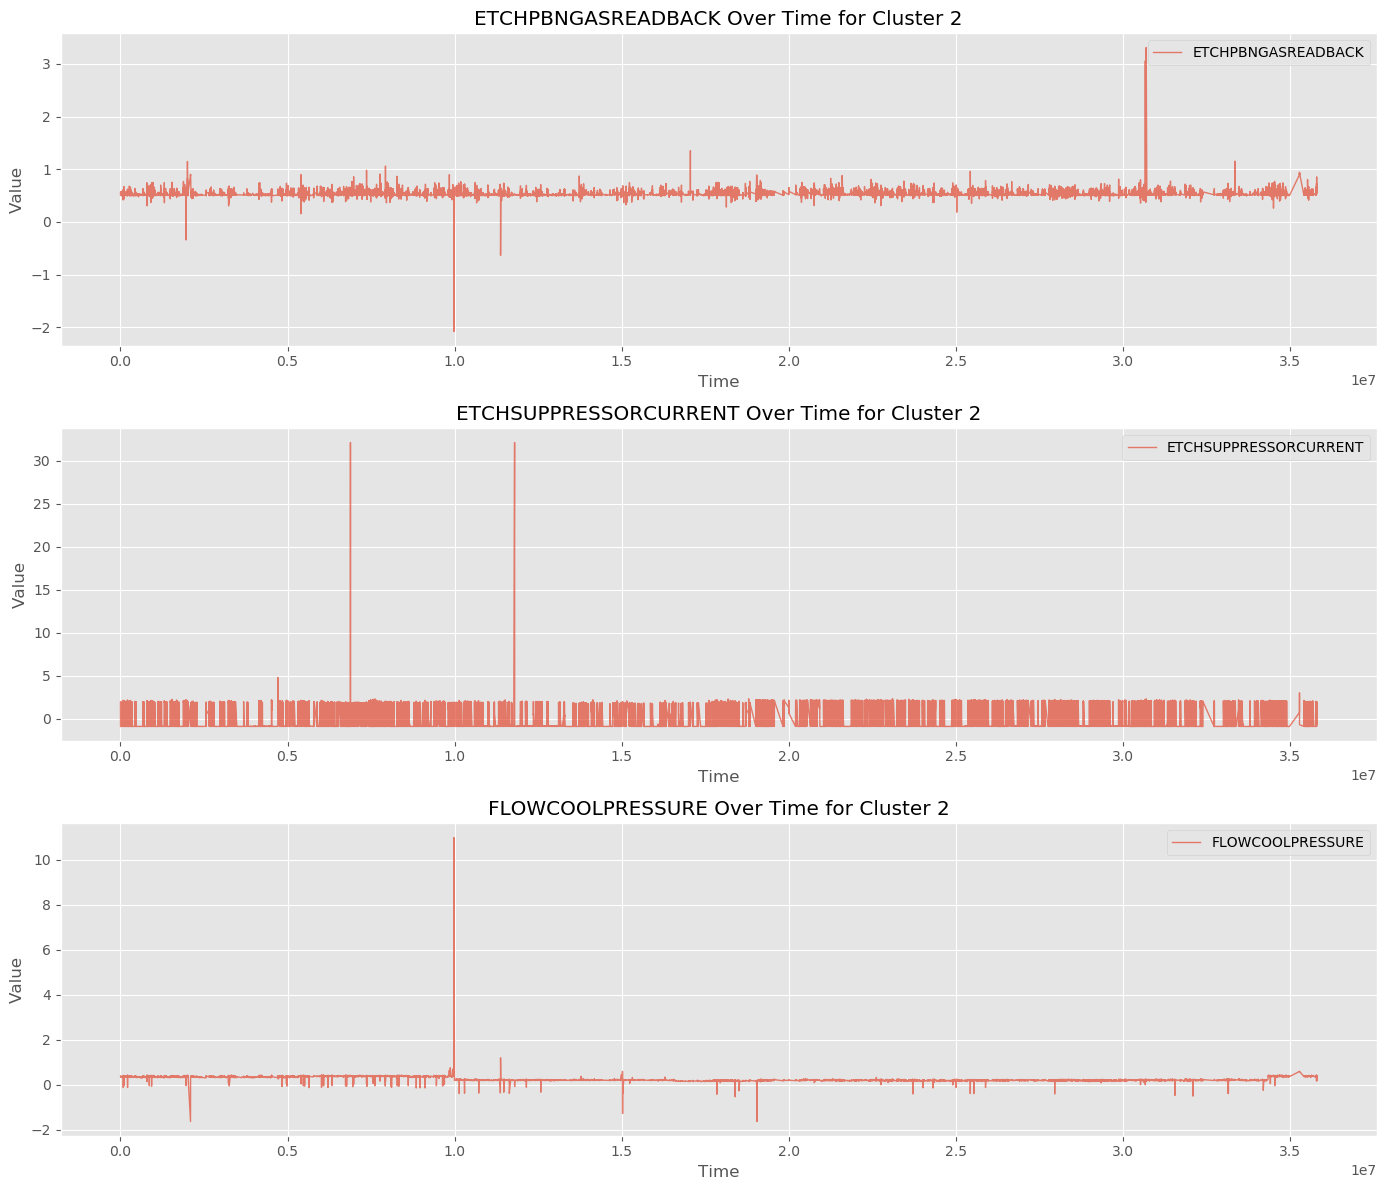

In [33]:
def plot_features_over_time(cluster_data, cluster_id):
    features = ['ETCHPBNGASREADBACK', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLPRESSURE']
    
    plt.figure(figsize=(14, 12))
    
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        plt.plot(cluster_data['time'], cluster_data[feature], label=feature, alpha=0.7, linestyle='-', linewidth=1)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'{feature} Over Time for Cluster {cluster_id}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot time series for Cluster 0
cluster_0_data = df[df['cluster_3'] == 0]
plot_features_over_time(cluster_0_data, 0)

# Plot time series for Cluster 1
cluster_1_data = df[df['cluster_3'] == 1]
plot_features_over_time(cluster_1_data, 1)

# Plot time series for Cluster 2
cluster_2_data = df[df['cluster_3'] == 2]
plot_features_over_time(cluster_2_data, 2)


### Comparative Analysis Summery:

#### 1. **Feature Importance**:
   - **ETCHPBNGASREADBACK** and **ETCHSUPPRESSORCURRENT** are the two most important features that strongly affect the clustering.
   - **FLOWCOOLPRESSURE** also has some influence but is significantly less important than the top two features.
   - Other features like **ETCHBEAMCURRENT**, **ETCHSUPPRESSORVOLTAGE**, and **recipe_step** contribute minimally to the clustering process.

#### 2. **Cluster Analysis**:
   - **Cluster 0**:
     - **ETCHPBNGASREADBACK** has consistently low values, with most data points clustered around -2. 
     - **ETCHSUPPRESSORCURRENT** is tightly grouped around -0.9, showing low variability.
     - **FLOWCOOLPRESSURE** has mostly negative values, indicating lower pressures for this cluster.

   - **Cluster 1**:
     - **ETCHPBNGASREADBACK** shows a tighter grouping around positive values, with some outliers.
     - **ETCHSUPPRESSORCURRENT** shows a wider range of variability, with values spread between -0.9 and 0.8.
     - **FLOWCOOLPRESSURE** has a moderate range, with values generally close to zero but with significant outliers.

   - **Cluster 2**:
     - **ETCHPBNGASREADBACK** and **ETCHSUPPRESSORCURRENT** show some extreme outliers, with **SUPPRESSORCURRENT** reaching values as high as 32.
     - **FLOWCOOLPRESSURE** is generally clustered around positive values but also shows extreme outliers.

#### 3. **Outliers**:
   - Both **Cluster 1** and **Cluster 2** exhibit more extreme outliers, especially in **FLOWCOOLPRESSURE** and **ETCHSUPPRESSORCURRENT**.
   - These outliers could indicate abnormal process conditions or operational anomalies that need further investigation.

#### 4. **Time Series Analysis**:
   - **Cluster 0**: Time series plots suggest consistent operation over time, with fewer spikes or anomalies in the key features.
   - **Cluster 1**: Shows significant variability over time, with frequent spikes in **FLOWCOOLPRESSURE** and **SUPPRESSORCURRENT**, suggesting unstable behavior.
   - **Cluster 2**: Appears more stable, but large spikes in **ETCHSUPPRESSORCURRENT** and **FLOWCOOLPRESSURE** could indicate critical operational issues during specific time windows.

#### Conclusion:
- **Cluster 0** represents stable operating conditions, with low variability and minimal outliers.
- **Cluster 1** displays high variability, particularly in **SUPPRESSORCURRENT** and **FLOWCOOLPRESSURE**, indicating unstable or erratic operations.
- **Cluster 2** shows mixed behavior, with some extreme outliers, especially in **SUPPRESSORCURRENT**, suggesting potential issues that need further investigation.

This analysis helps to identify the critical features affecting the clustering and to isolate operational anomalies across the clusters.

## Anomaly Detection

### Experimenting on a sample Dataset

In this section we are applying the LSTM model on a fraction of the dataset, based on the results we configure how to move forward.

In [35]:
df_fault = df[df['fault'] == 1]
df_normal = df[df['fault'] == 0].sample(1000000-13693, random_state=42)

all_data_train = pd.concat([df_normal, df_fault])

# Separating features and labels
X = all_data_train.drop(columns=['fault'])  # Assuming 'fault' is your label
y = all_data_train['fault']

# Normalize the features (this is for the LSTM)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
timesteps = 30  # You can experiment with this value

# Reshape input data into 3D [samples, timesteps, features]
X_lstm = []
y_lstm = []

for i in range(timesteps, len(X_scaled)):
    X_lstm.append(X_scaled[i-timesteps:i])
    y_lstm.append(y.iloc[i])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [38]:
# Define the LSTM model
model = Sequential()
# Add another LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Add another LSTM layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           78336     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 127,809
Trainable params: 127,809
Non-trainable params: 0
_________________________________________________________________


In [39]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [41]:

class DataGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.X_data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_X = self.X_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_X, batch_y

# Instantiate the generator
train_gen = DataGenerator(X_train, y_train, batch_size=64)
test_gen = DataGenerator(X_test, y_test, batch_size=64)

In [42]:
gc.collect()


65823

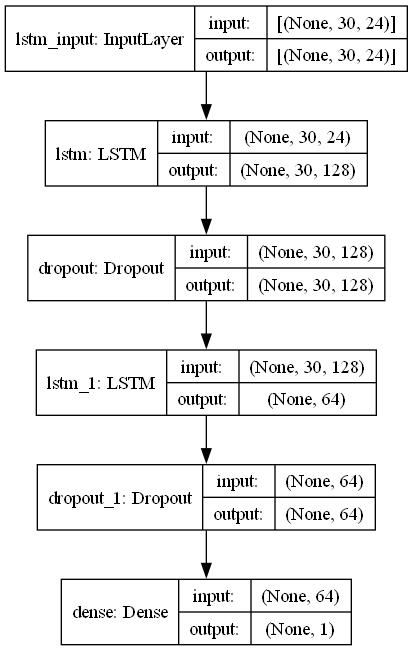

In [43]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='lstm_architecture.png', show_shapes=True, show_layer_names=True)


In [42]:
history = model.fit(train_gen, validation_data=test_gen, epochs=30, class_weight=class_weights_dict, callbacks=[early_stopping])


Epoch 1/30
12500/12500 [==============================] - 102s 8ms/step - loss: 0.0259 - accuracy: 0.9940 - val_loss: 4.2773e-05 - val_accuracy: 1.0000
Epoch 2/30
12500/12500 [==============================] - 95s 8ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 4.0289e-04 - val_accuracy: 1.0000
Epoch 3/30
12500/12500 [==============================] - 94s 8ms/step - loss: 0.0031 - accuracy: 0.9999 - val_loss: 5.0135e-05 - val_accuracy: 1.0000
Epoch 4/30
12500/12500 [==============================] - 93s 7ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 9.3579e-05 - val_accuracy: 1.0000


In [43]:
# Predict on the test set
y_probs = model.predict(X_test)

# Calculate the ROC-AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc_score}")


AUC-ROC: 0.9999999981888756


In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


In [45]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


Optimal Threshold: 0.06324837356805801


In [46]:
y_pred = (y_probs >= optimal_threshold).astype(int)


In [47]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9999949998499955
Precision: 0.9996429846483399
Recall: 1.0
F1 Score: 0.9998214604534904


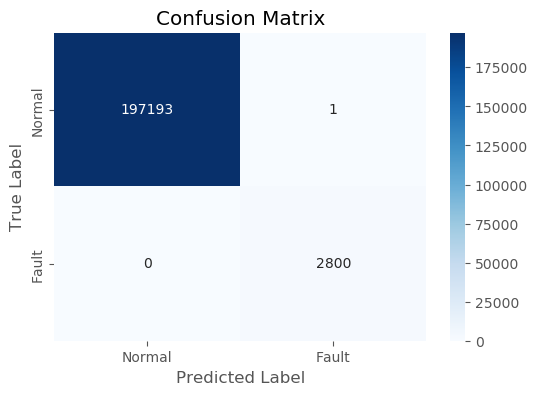

In [48]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Applyng LSTM on the entire dataset

Here we are going to apply the model on the entire dataset.

In [49]:
df_fault = df[df['fault'] == 1]
df_normal = df[df['fault'] == 0]

all_data_train = pd.concat([df_normal, df_fault])

# Separating features and labels
X = all_data_train.drop(columns=['fault'])  # Assuming 'fault' is your label
y = all_data_train['fault']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
timesteps = 30

# Reshape input data into 3D [samples, timesteps, features]
X_lstm = []
y_lstm = []

for i in range(timesteps, len(X_scaled)):
    X_lstm.append(X_scaled[i-timesteps:i])
    y_lstm.append(y.iloc[i])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [52]:
# Define the LSTM model
model = Sequential()
# Add another LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Add another LSTM layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 128)           78336     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 127,809
Trainable params: 127,809
Non-trainable params: 0
_________________________________________________________________


In [53]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [55]:

class DataGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.X_data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_X = self.X_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_X, batch_y

# Instantiate the generator
train_gen = DataGenerator(X_train, y_train, batch_size=64)
test_gen = DataGenerator(X_test, y_test, batch_size=64)

In [56]:
gc.collect()


42649

In [57]:
history = model.fit(train_gen, validation_data=test_gen, epochs=30, class_weight=class_weights_dict, callbacks=[early_stopping])


Epoch 1/30
46451/46451 [==============================] - 354s 8ms/step - loss: 0.1041 - accuracy: 0.9584 - val_loss: 0.1789 - val_accuracy: 0.9164
Epoch 2/30
46451/46451 [==============================] - 352s 8ms/step - loss: 0.0558 - accuracy: 0.9834 - val_loss: 0.0358 - val_accuracy: 0.9920
Epoch 3/30
46451/46451 [==============================] - 351s 8ms/step - loss: 0.0440 - accuracy: 0.9887 - val_loss: 0.0045 - val_accuracy: 0.9989
Epoch 4/30
46451/46451 [==============================] - 347s 7ms/step - loss: 0.0217 - accuracy: 0.9962 - val_loss: 4.5604e-04 - val_accuracy: 1.0000
Epoch 5/30
46451/46451 [==============================] - 349s 8ms/step - loss: 0.0243 - accuracy: 0.9953 - val_loss: 0.0132 - val_accuracy: 0.9949
Epoch 6/30
46451/46451 [==============================] - 351s 8ms/step - loss: 0.0243 - accuracy: 0.9956 - val_loss: 1.8953e-04 - val_accuracy: 1.0000
Epoch 7/30
46451/46451 [==============================] - 352s 8ms/step - loss: 0.0120 - accuracy: 0.999

In [58]:
# Predict on the test set
y_probs = model.predict(X_test)

# Calculate the ROC-AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc_score}")


AUC-ROC: 1.0


In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


In [60]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


Optimal Threshold: 0.8111990690231323


In [61]:
y_pred = (y_probs >= optimal_threshold).astype(int)


In [62]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


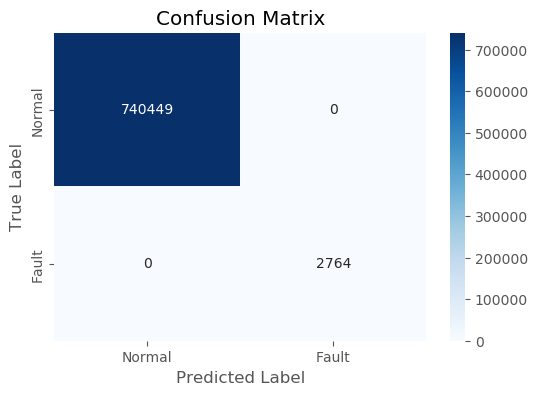

In [63]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [64]:
model.save('best_model.h5')

## Applying to TEST Dataset

### Loading the new test dataset

In [65]:
data_path_test = r'C:\Users\ADMIN\Downloads\test_no_fault.csv'
try:
    test_df = pd.read_csv(data_path_test)
    test_df = test_df.drop(columns=['Unnamed: 0'], errors='ignore')  # Drop irrelevant columns
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File not found at {data_path_test}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.


In [66]:
# Display the first few rows of the dataset
test_df.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,41751466,06M01,263,8712,12977313,233,1,-1.342161,-1.081421,-1.321456,...,0.272474,0.566292,-0.044422,-0.039883,-0.139343,0.0,1.928271,0.016701,0.843534,-0.704569
1,41751470,06M01,263,8712,12977313,233,1,-1.342161,-1.262697,-1.321152,...,0.825219,0.566292,-0.044422,-0.039883,-0.139343,0.0,1.928271,0.016701,0.843534,-0.704569
2,41751474,06M01,263,8712,12977313,233,1,-0.350620,-1.269103,-1.321456,...,0.851433,0.566292,-0.044422,-0.039883,-0.139343,0.0,1.928271,0.016701,0.843534,-0.704569
3,41751478,06M01,263,8712,12977313,233,1,0.026634,-0.372887,-1.321304,...,0.851433,0.591516,-0.044422,-0.039883,-0.139343,0.0,1.928275,0.016704,0.843538,-0.704569
4,41751482,06M01,263,8712,12977313,233,1,0.304667,-0.708670,3.492769,...,0.864438,0.591516,-0.044422,-0.039883,-0.139343,0.0,1.928282,0.016707,0.843541,-0.704569


### Data Preprocessing

In [67]:
# Drop the 'Tool' column
test_df = test_df.drop('Tool', axis=1)

# Adjust the 'time' column to start from zero
test_df['time'] = test_df['time'] - test_df.loc[0, 'time']

# Display the column names to understand the data structure
test_df.columns

Index(['time', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step',
       'IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
       'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
       'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
       'FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE',
       'FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER',
       'ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION'],
      dtype='object')

In [68]:
# Convert categorical columns to the 'object' data type
cat_cols = ['stage', 'Lot', 'recipe', 'recipe_step']
for col in cat_cols:
    test_df[col] = test_df[col].astype('object')

# Display data types to ensure correct conversions
test_df.dtypes

time                         int64
stage                       object
Lot                         object
runnum                       int64
recipe                      object
recipe_step                 object
IONGAUGEPRESSURE           float64
ETCHBEAMVOLTAGE            float64
ETCHBEAMCURRENT            float64
ETCHSUPPRESSORVOLTAGE      float64
ETCHSUPPRESSORCURRENT      float64
FLOWCOOLFLOWRATE           float64
FLOWCOOLPRESSURE           float64
ETCHGASCHANNEL1READBACK    float64
ETCHPBNGASREADBACK         float64
FIXTURETILTANGLE           float64
ROTATIONSPEED              float64
ACTUALROTATIONANGLE        float64
FIXTURESHUTTERPOSITION     float64
ETCHSOURCEUSAGE            float64
ETCHAUXSOURCETIMER         float64
ETCHAUX2SOURCETIMER        float64
ACTUALSTEPDURATION         float64
dtype: object

In [69]:
# reducing RAM usage by converting int64 and float64 to 16bits
for cols in test_df.columns.values :
    if test_df[cols].dtypes == 'int64' :
        if (cols == 'runnum') or (cols == 'time'):
            continue
        test_df[cols] = test_df[cols].astype('int16')
    elif test_df[cols].dtypes == 'float64' :
        test_df[cols] = test_df[cols].astype('float16')

test_df.dtypes

time                         int64
stage                       object
Lot                         object
runnum                       int64
recipe                      object
recipe_step                 object
IONGAUGEPRESSURE           float16
ETCHBEAMVOLTAGE            float16
ETCHBEAMCURRENT            float16
ETCHSUPPRESSORVOLTAGE      float16
ETCHSUPPRESSORCURRENT      float16
FLOWCOOLFLOWRATE           float16
FLOWCOOLPRESSURE           float16
ETCHGASCHANNEL1READBACK    float16
ETCHPBNGASREADBACK         float16
FIXTURETILTANGLE           float16
ROTATIONSPEED              float16
ACTUALROTATIONANGLE        float16
FIXTURESHUTTERPOSITION     float16
ETCHSOURCEUSAGE            float16
ETCHAUXSOURCETIMER         float16
ETCHAUX2SOURCETIMER        float16
ACTUALSTEPDURATION         float16
dtype: object

In [70]:
# Label Encoding
for cols in cat_cols :
    le = LabelEncoder()
    test_df[cols] = le.fit_transform(list(test_df[cols])).astype('int16')

test_df.dtypes

time                         int64
stage                        int16
Lot                          int16
runnum                       int64
recipe                       int16
recipe_step                  int16
IONGAUGEPRESSURE           float16
ETCHBEAMVOLTAGE            float16
ETCHBEAMCURRENT            float16
ETCHSUPPRESSORVOLTAGE      float16
ETCHSUPPRESSORCURRENT      float16
FLOWCOOLFLOWRATE           float16
FLOWCOOLPRESSURE           float16
ETCHGASCHANNEL1READBACK    float16
ETCHPBNGASREADBACK         float16
FIXTURETILTANGLE           float16
ROTATIONSPEED              float16
ACTUALROTATIONANGLE        float16
FIXTURESHUTTERPOSITION     float16
ETCHSOURCEUSAGE            float16
ETCHAUXSOURCETIMER         float16
ETCHAUX2SOURCETIMER        float16
ACTUALSTEPDURATION         float16
dtype: object

In [71]:
if 'cluster_3' not in test_df.columns:
    test_df['cluster_3'] = 0

In [72]:
X_test_scaled = scaler.transform(test_df)

# Reshape the test data to match LSTM input requirements
timesteps = 30
X_test_lstm = []

for i in range(timesteps, len(X_test_scaled)):
    X_test_lstm.append(X_test_scaled[i-timesteps:i])

X_test_lstm = np.array(X_test_lstm)

print(f'Shape of X_test_lstm: {X_test_lstm.shape}') 

Shape of X_test_lstm: (1270706, 30, 24)


### Applying Model to Test Data

In [73]:
# Load the pre-trained model
model = load_model('best_model.h5')

In [74]:
# Use the model to predict on the reshaped test data
y_test_prob = model.predict(X_test_lstm)


In [83]:
# Assuming a threshold of 0.5 for binary classification (adjust based on your analysis)
threshold = 0.5
y_pred = (y_test_prob >= threshold).astype(int)

# Print the first few predictions
print(y_pred[:10])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [84]:
gc.collect()

8983

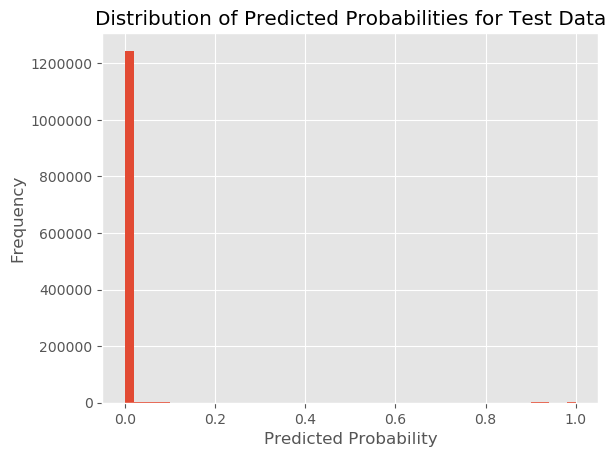

In [85]:
plt.hist(y_test_prob, bins=50)
plt.title('Distribution of Predicted Probabilities for Test Data')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [86]:
unique, counts = np.unique(y_pred, return_counts=True)
class_distribution = dict(zip(unique, counts))

print(f"Class distribution in test data predictions: {class_distribution}")


Class distribution in test data predictions: {0: 1257859, 1: 12847}


In [87]:
y_train_pred_prob = model.predict(train_gen)  # Predicted probabilities for the training data

mse_train = mean_squared_error(y_train, y_train_pred_prob)
r2_train = r2_score(y_train, y_train_pred_prob)

print(f"Training MSE: {mse_train}")
print(f"Training R²: {r2_train}")

Training MSE: 2.371782784393872e-06
Training R²: 0.9993524593501637


In [88]:
y_test_pred_prob = model.predict(X_test_lstm)  # Predicted probabilities for the test data

mse_test = mean_squared_error(np.zeros_like(y_test_pred_prob), y_test_pred_prob)  # No true labels, assuming zeros
print(f"Test MSE (based on predicted probabilities): {mse_test}")


Test MSE (based on predicted probabilities): 0.0077182333916425705


In [89]:
# Comparison between training and test MSE
print(f"Comparison between Training MSE: {mse_train} and Test MSE: {mse_test}")


Comparison between Training MSE: 2.371782784393872e-06 and Test MSE: 0.0077182333916425705


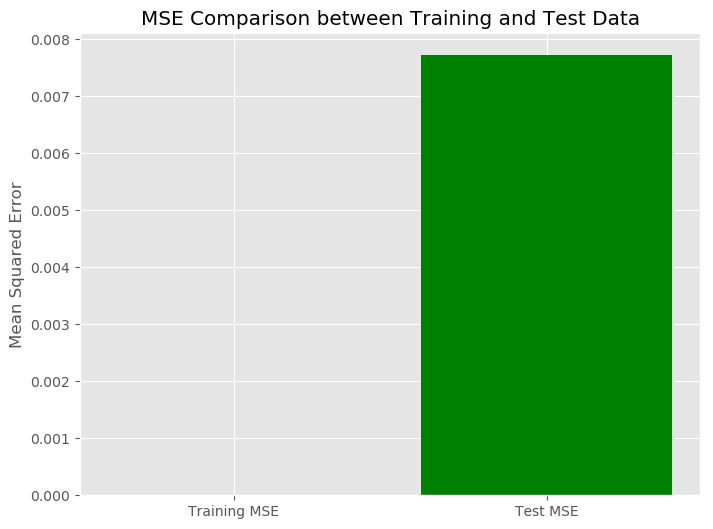

In [90]:
# Define the data for the plot
mse_values = [mse_train, mse_test]
labels = ['Training MSE', 'Test MSE']

# Create a bar plot to compare the MSE
plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['blue', 'green'])
plt.title('MSE Comparison between Training and Test Data')
plt.ylabel('Mean Squared Error')
plt.show()